In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANESTESIOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 12 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=239.8, y1=102.1
Page 1, Q1, A: Yellow pixels: 213
Page 1, Q1, A: Total non-white pixels: 1069
Page 1, Q1, A: Yellow percentage: 19.9%


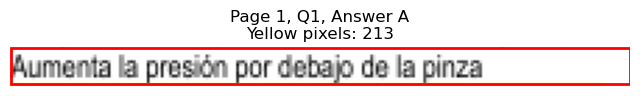

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=226.8, y1=114.7
Page 1, Q1, B: Yellow pixels: 2120
Page 1, Q1, B: Total non-white pixels: 2717
Page 1, Q1, B: Yellow percentage: 78.0%


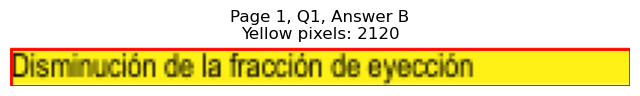

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=510.6, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 908
Page 1, Q1, C: Yellow percentage: 0.0%


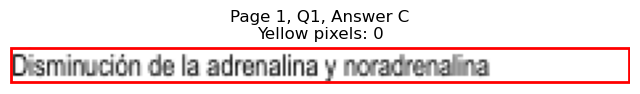

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=497.6, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 869
Page 1, Q1, D: Yellow percentage: 0.0%


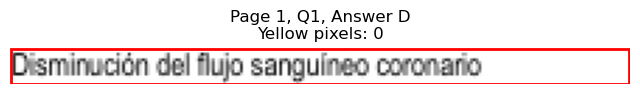


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=168.6, y1=152.6
Page 1, Q2, A: Yellow pixels: 151
Page 1, Q2, A: Total non-white pixels: 656
Page 1, Q2, A: Yellow percentage: 23.0%


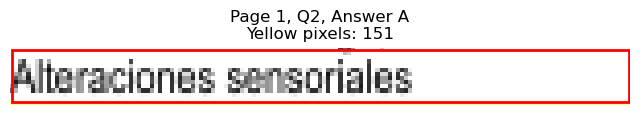

Page 1, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=179.2, y1=165.2
Page 1, Q2, B: Yellow pixels: 1699
Page 1, Q2, B: Total non-white pixels: 2268
Page 1, Q2, B: Yellow percentage: 74.9%


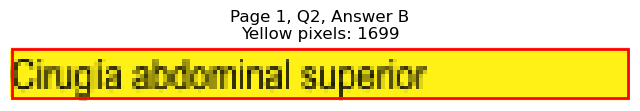

Page 1, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=379.7, y1=152.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 274
Page 1, Q2, C: Yellow percentage: 0.0%


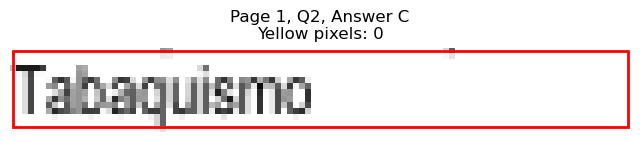

Page 1, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=410.8, y1=165.2
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 435
Page 1, Q2, D: Yellow percentage: 0.0%


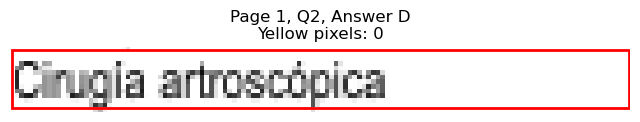


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=143.1, y1=203.0
Page 1, Q3, A: Yellow pixels: 1305
Page 1, Q3, A: Total non-white pixels: 1638
Page 1, Q3, A: Yellow percentage: 79.7%


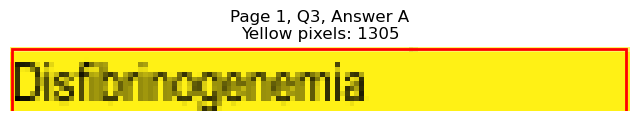

Page 1, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=140.5, y1=215.6
Page 1, Q3, B: Yellow pixels: 119
Page 1, Q3, B: Total non-white pixels: 510
Page 1, Q3, B: Yellow percentage: 23.3%


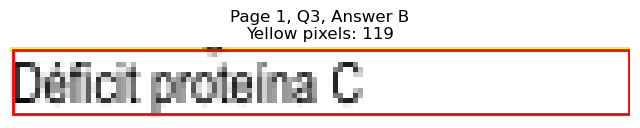

Page 1, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=419.8, y1=203.0
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 475
Page 1, Q3, C: Yellow percentage: 0.0%


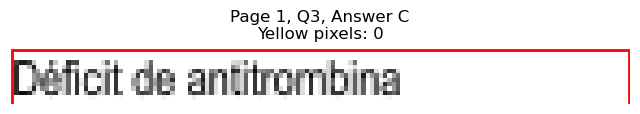

Page 1, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=486.6, y1=215.6
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 803
Page 1, Q3, D: Yellow percentage: 0.0%


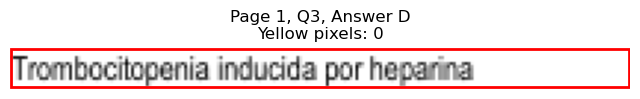


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=121.9, y1=266.1
Page 1, Q4, A: Yellow pixels: 1138
Page 1, Q4, A: Total non-white pixels: 1456
Page 1, Q4, A: Yellow percentage: 78.2%


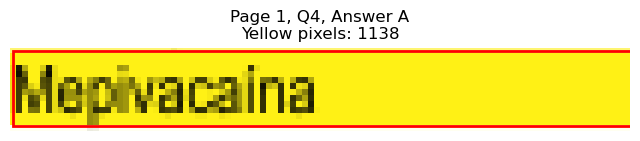

Page 1, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=106.9, y1=278.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 270
Page 1, Q4, B: Yellow percentage: 0.0%


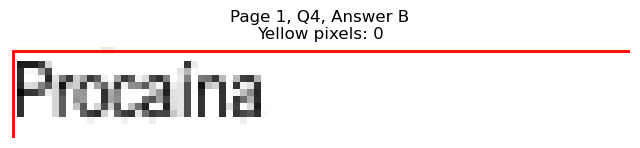

Page 1, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=381.7, y1=266.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 280
Page 1, Q4, C: Yellow percentage: 0.0%


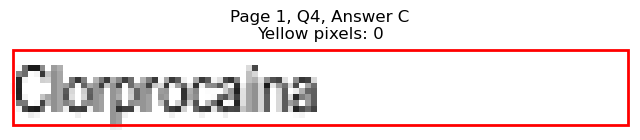

Page 1, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=373.1, y1=278.7
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 218
Page 1, Q4, D: Yellow percentage: 0.0%


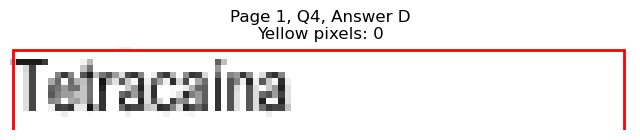


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=156.0, y1=354.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 480
Page 1, Q5, A: Yellow percentage: 0.0%


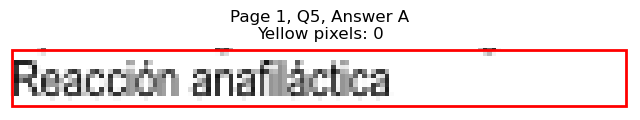

Page 1, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=151.6, y1=367.2
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 420
Page 1, Q5, B: Yellow percentage: 0.0%


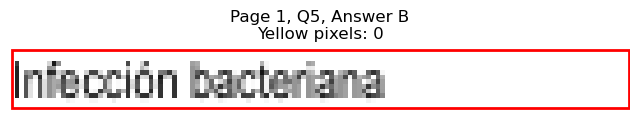

Page 1, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=422.8, y1=354.6
Page 1, Q5, C: Yellow pixels: 146
Page 1, Q5, C: Total non-white pixels: 641
Page 1, Q5, C: Yellow percentage: 22.8%


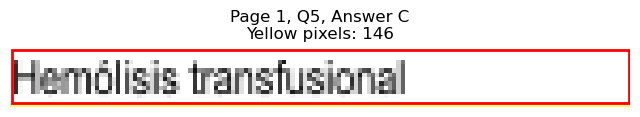

Page 1, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=424.4, y1=367.2
Page 1, Q5, D: Yellow pixels: 1575
Page 1, Q5, D: Total non-white pixels: 2072
Page 1, Q5, D: Yellow percentage: 76.0%


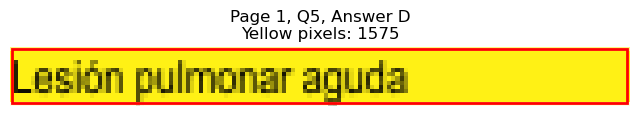


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=80.9, y1=430.3
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 69
Page 1, Q6, A: Yellow percentage: 0.0%


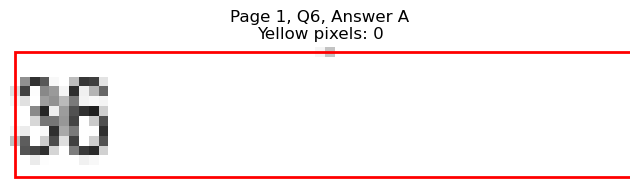

Page 1, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=80.9, y1=442.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 58
Page 1, Q6, B: Yellow percentage: 0.0%


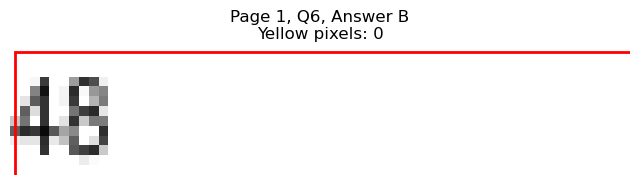

Page 1, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=340.1, y1=430.3
Page 1, Q6, C: Yellow pixels: 725
Page 1, Q6, C: Total non-white pixels: 896
Page 1, Q6, C: Yellow percentage: 80.9%


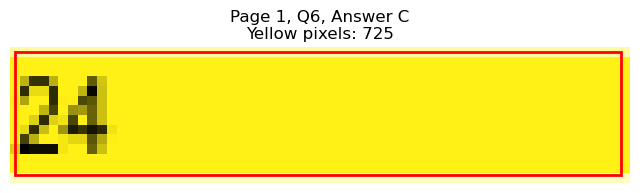

Page 1, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=340.1, y1=442.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 112
Page 1, Q6, D: Yellow percentage: 0.0%


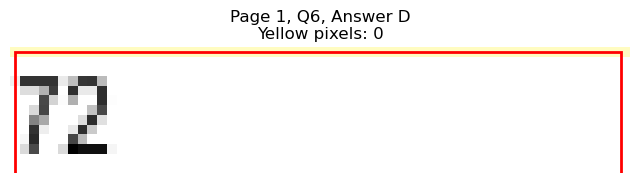


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=112.0, y1=480.7
Page 1, Q7, A: Yellow pixels: 1061
Page 1, Q7, A: Total non-white pixels: 1222
Page 1, Q7, A: Yellow percentage: 86.8%


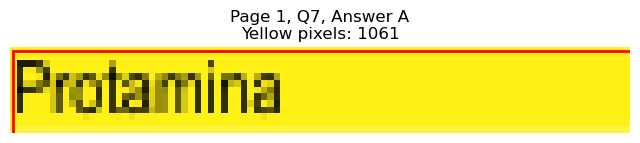

Page 1, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=114.5, y1=493.4
Page 1, Q7, B: Yellow pixels: 97
Page 1, Q7, B: Total non-white pixels: 299
Page 1, Q7, B: Yellow percentage: 32.4%


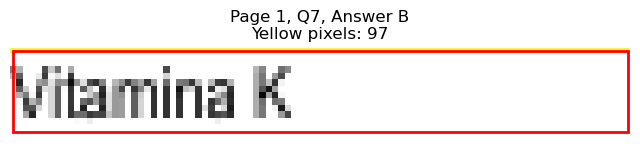

Page 1, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=384.2, y1=480.7
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 296
Page 1, Q7, C: Yellow percentage: 0.0%


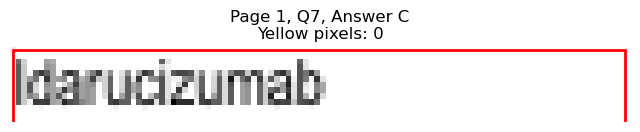

Page 1, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=390.3, y1=493.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 303
Page 1, Q7, D: Yellow percentage: 0.0%


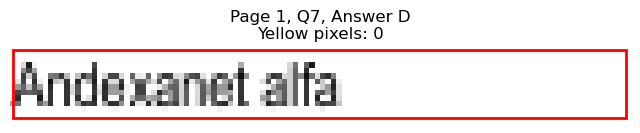


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=76.5, y0=518.6, x1=139.2, y1=531.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 288
Page 1, Q8, A: Yellow percentage: 0.0%


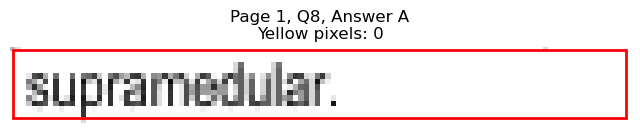

Page 1, Q8 - B: Detected box: x0=77.5, y0=531.2, x1=119.2, y1=543.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 202
Page 1, Q8, B: Yellow percentage: 0.0%


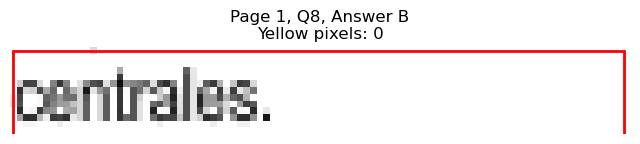

Page 1, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=381.2, y1=531.2
Page 1, Q8, C: Yellow pixels: 105
Page 1, Q8, C: Total non-white pixels: 362
Page 1, Q8, C: Yellow percentage: 29.0%


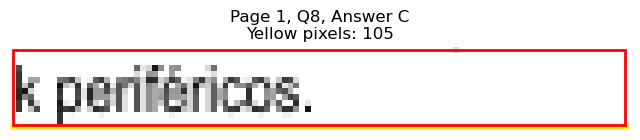

Page 1, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=378.1, y1=543.8
Page 1, Q8, D: Yellow pixels: 1147
Page 1, Q8, D: Total non-white pixels: 1326
Page 1, Q8, D: Yellow percentage: 86.5%


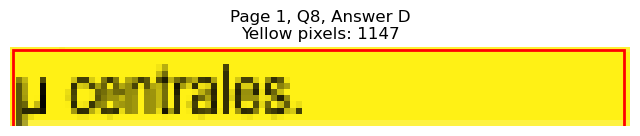


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=569.1, x1=129.0, y1=581.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 288
Page 1, Q9, A: Yellow percentage: 0.0%


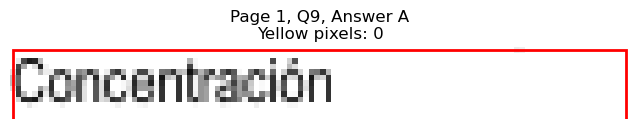

Page 1, Q9 - B: Detected box: x0=68.3, y0=581.7, x1=91.8, y1=594.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 113
Page 1, Q9, B: Yellow percentage: 0.0%


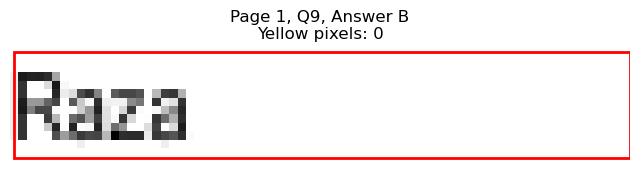

Page 1, Q9 - C: Detected box: x0=327.5, y0=569.1, x1=365.7, y1=581.8
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 269
Page 1, Q9, C: Yellow percentage: 0.0%


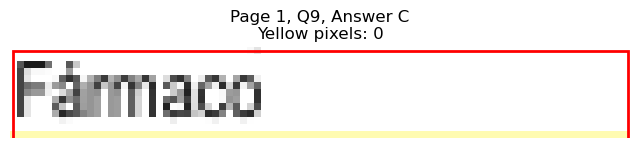

Page 1, Q9 - D: Detected box: x0=327.5, y0=581.7, x1=392.8, y1=594.4
Page 1, Q9, D: Yellow pixels: 1154
Page 1, Q9, D: Total non-white pixels: 1624
Page 1, Q9, D: Yellow percentage: 71.1%


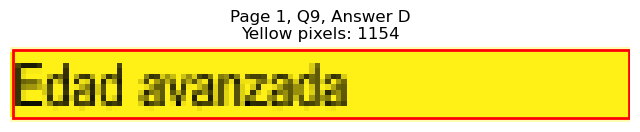


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=178.1, y1=644.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 569
Page 1, Q10, A: Yellow percentage: 0.0%


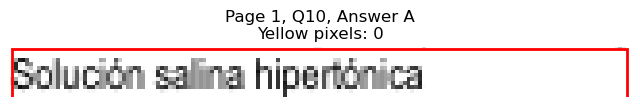

Page 1, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=118.5, y1=657.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 253
Page 1, Q10, B: Yellow percentage: 0.0%


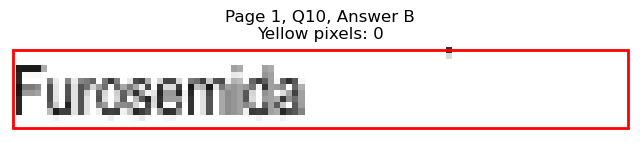

Page 1, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=359.1, y1=644.9
Page 1, Q10, C: Yellow pixels: 940
Page 1, Q10, C: Total non-white pixels: 1079
Page 1, Q10, C: Yellow percentage: 87.1%


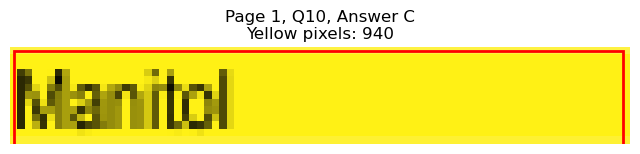

Page 1, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=391.3, y1=657.5
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 318
Page 1, Q10, D: Yellow percentage: 0.0%


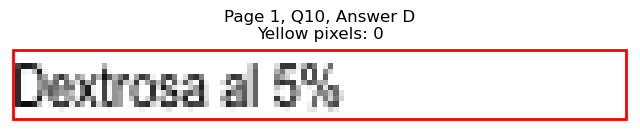


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=107.9, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 198
Page 1, Q11, A: Yellow percentage: 0.0%


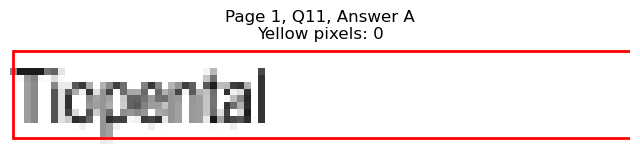

Page 1, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=107.9, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 182
Page 1, Q11, B: Yellow percentage: 0.0%


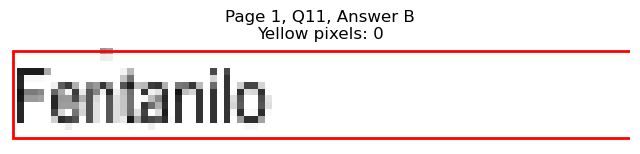

Page 1, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=373.6, y1=708.0
Page 1, Q11, C: Yellow pixels: 97
Page 1, Q11, C: Total non-white pixels: 439
Page 1, Q11, C: Yellow percentage: 22.1%


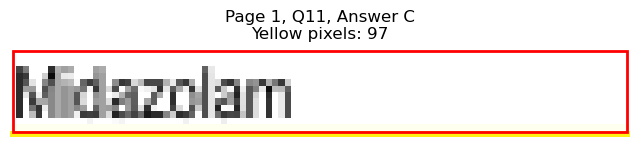

Page 1, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=363.7, y1=720.6
Page 1, Q11, D: Yellow pixels: 993
Page 1, Q11, D: Total non-white pixels: 1218
Page 1, Q11, D: Yellow percentage: 81.5%


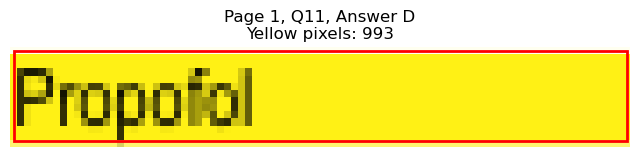


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)




Page 1, Q12 - A: Detected box: x0=68.3, y0=745.8, x1=126.1, y1=758.4
Page 1, Q12, A: Yellow pixels: 0
Page 1, Q12, A: Total non-white pixels: 293
Page 1, Q12, A: Yellow percentage: 0.0%


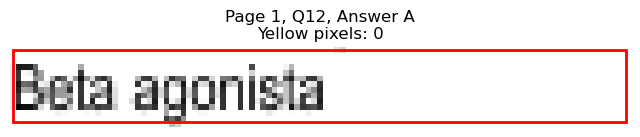

Page 1, Q12 - B: Detected box: x0=68.3, y0=758.5, x1=130.5, y1=771.2
Page 1, Q12, B: Yellow pixels: 1215
Page 1, Q12, B: Total non-white pixels: 1582
Page 1, Q12, B: Yellow percentage: 76.8%


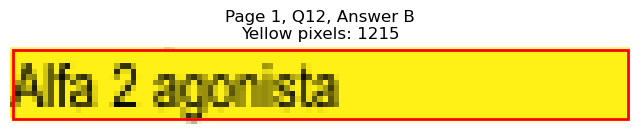

Page 1, Q12 - C: Detected box: x0=327.5, y0=745.8, x1=386.7, y1=758.4
Page 1, Q12, C: Yellow pixels: 0
Page 1, Q12, C: Total non-white pixels: 320
Page 1, Q12, C: Yellow percentage: 0.0%


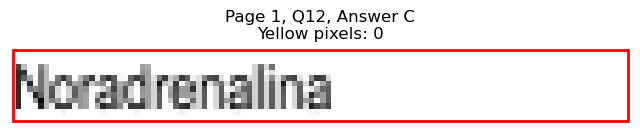

Page 1, Q12 - D: Detected box: x0=327.5, y0=758.5, x1=373.1, y1=771.2
Page 1, Q12, D: Yellow pixels: 0
Page 1, Q12, D: Total non-white pixels: 224
Page 1, Q12, D: Yellow percentage: 0.0%


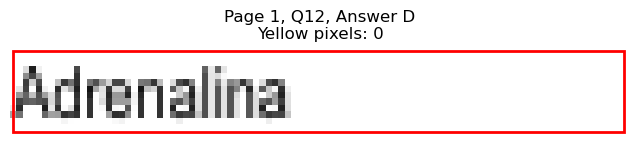


Page 1, Q12 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=107.9, y1=102.1
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 181
Page 2, Q1, A: Yellow percentage: 0.0%


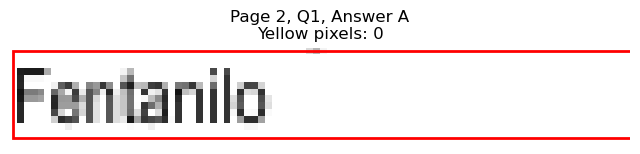

Page 2, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=114.4, y1=114.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 247
Page 2, Q1, B: Yellow percentage: 0.0%


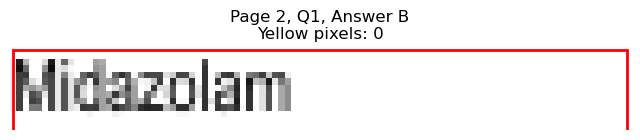

Page 2, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=368.2, y1=102.1
Page 2, Q1, C: Yellow pixels: 1045
Page 2, Q1, C: Total non-white pixels: 1288
Page 2, Q1, C: Yellow percentage: 81.1%


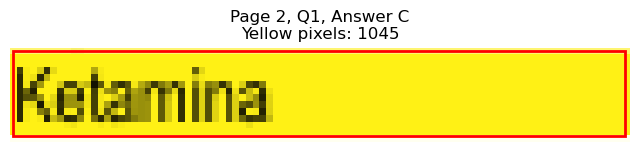

Page 2, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=385.7, y1=114.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 401
Page 2, Q1, D: Yellow percentage: 0.0%


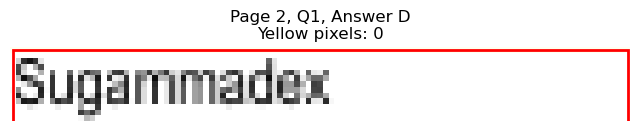


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=182.2, y1=152.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 541
Page 2, Q2, A: Yellow percentage: 0.0%


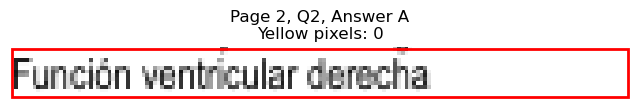

Page 2, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=176.2, y1=165.2
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 572
Page 2, Q2, B: Yellow percentage: 0.0%


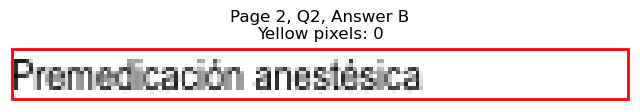

Page 2, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=429.3, y1=152.6
Page 2, Q2, C: Yellow pixels: 1606
Page 2, Q2, C: Total non-white pixels: 2142
Page 2, Q2, C: Yellow percentage: 75.0%


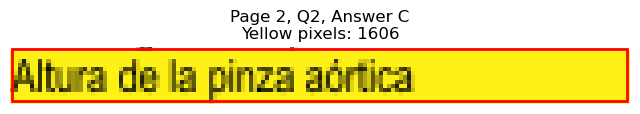

Page 2, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=441.4, y1=165.2
Page 2, Q2, D: Yellow pixels: 165
Page 2, Q2, D: Total non-white pixels: 737
Page 2, Q2, D: Yellow percentage: 22.4%


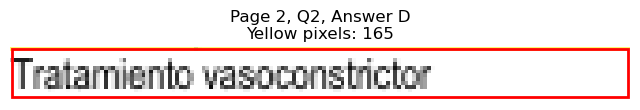


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=116.4, y1=215.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 245
Page 2, Q3, A: Yellow percentage: 0.0%


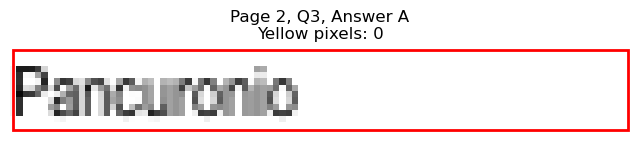

Page 2, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=115.5, y1=228.3
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 260
Page 2, Q3, B: Yellow percentage: 0.0%


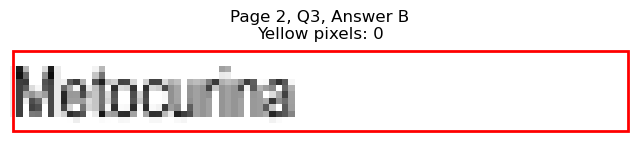

Page 2, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=368.7, y1=215.6
Page 2, Q3, C: Yellow pixels: 1022
Page 2, Q3, C: Total non-white pixels: 1288
Page 2, Q3, C: Yellow percentage: 79.3%


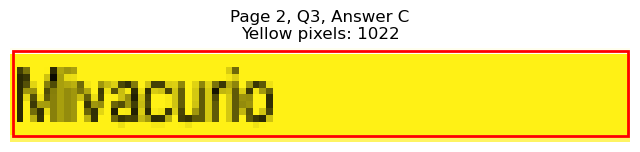

Page 2, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=378.2, y1=228.3
Page 2, Q3, D: Yellow pixels: 102
Page 2, Q3, D: Total non-white pixels: 365
Page 2, Q3, D: Yellow percentage: 27.9%


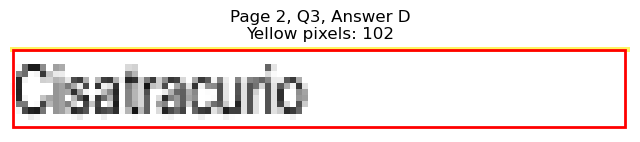


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=115.9, y1=266.1
Page 2, Q4, A: Yellow pixels: 98
Page 2, Q4, A: Total non-white pixels: 341
Page 2, Q4, A: Yellow percentage: 28.7%


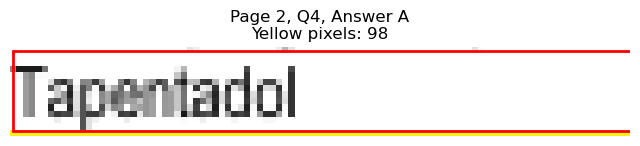

Page 2, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=115.5, y1=278.7
Page 2, Q4, B: Yellow pixels: 1049
Page 2, Q4, B: Total non-white pixels: 1274
Page 2, Q4, B: Yellow percentage: 82.3%


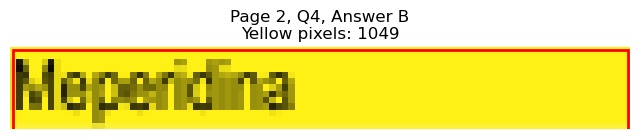

Page 2, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=368.2, y1=266.1
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 197
Page 2, Q4, C: Yellow percentage: 0.0%


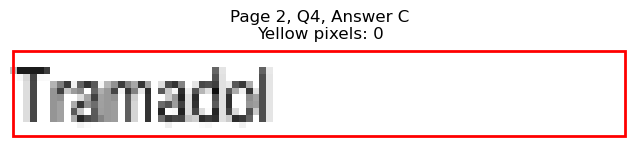

Page 2, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=368.2, y1=278.7
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 205
Page 2, Q4, D: Yellow percentage: 0.0%


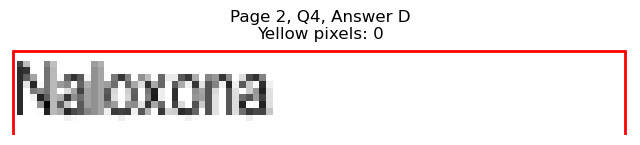


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=80.9, y1=341.9
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 51
Page 2, Q5, A: Yellow percentage: 0.0%


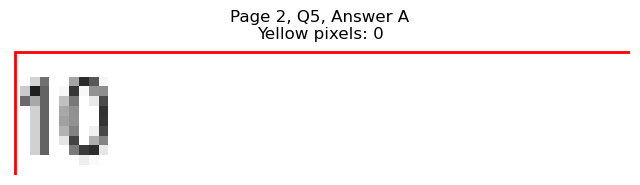

Page 2, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=65.2, y1=354.6
Page 2, Q5, B: Yellow pixels: 718
Page 2, Q5, B: Total non-white pixels: 840
Page 2, Q5, B: Yellow percentage: 85.5%


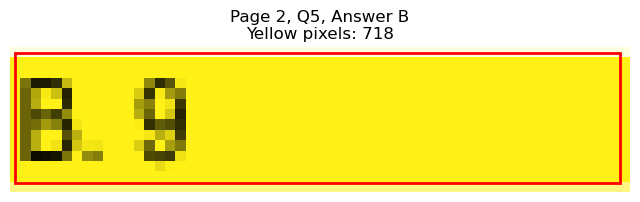

Page 2, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=340.1, y1=341.9
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 28
Page 2, Q5, C: Yellow percentage: 0.0%


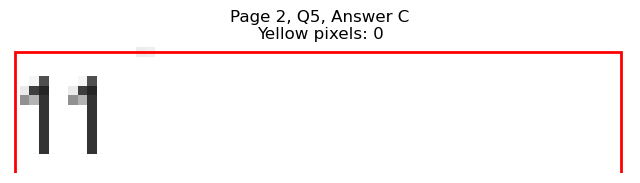

Page 2, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=324.4, y1=354.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 73
Page 2, Q5, D: Yellow percentage: 0.0%


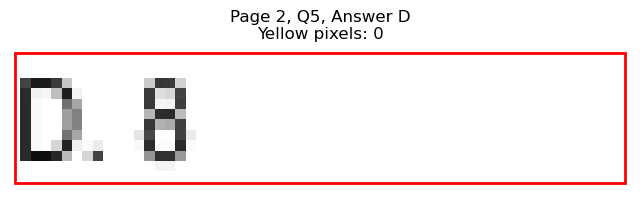


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=152.1, y1=392.4
Page 2, Q6, A: Yellow pixels: 1294
Page 2, Q6, A: Total non-white pixels: 1890
Page 2, Q6, A: Yellow percentage: 68.5%


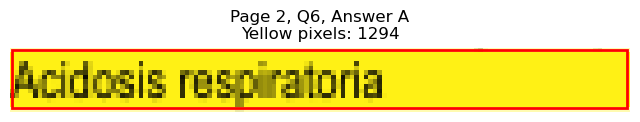

Page 2, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=138.6, y1=405.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 439
Page 2, Q6, B: Yellow percentage: 0.0%


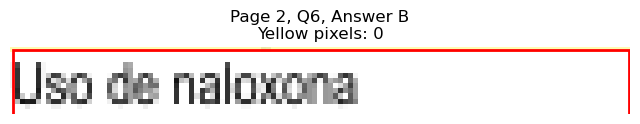

Page 2, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=439.0, y1=392.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 601
Page 2, Q6, C: Yellow percentage: 0.0%


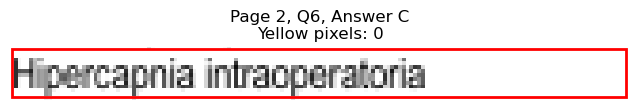

Page 2, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=403.4, y1=405.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 375
Page 2, Q6, D: Yellow percentage: 0.0%


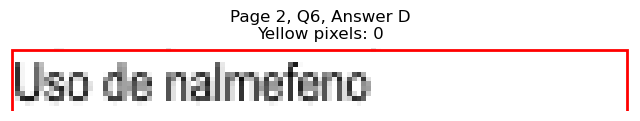


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=131.5, y1=468.1
Page 2, Q7, A: Yellow pixels: 114
Page 2, Q7, A: Total non-white pixels: 408
Page 2, Q7, A: Yellow percentage: 27.9%


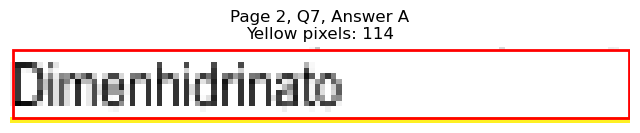

Page 2, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=111.4, y1=480.7
Page 2, Q7, B: Yellow pixels: 1036
Page 2, Q7, B: Total non-white pixels: 1222
Page 2, Q7, B: Yellow percentage: 84.8%


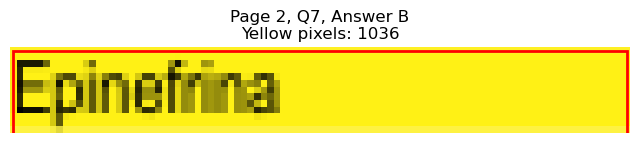

Page 2, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=371.2, y1=468.1
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 228
Page 2, Q7, C: Yellow percentage: 0.0%


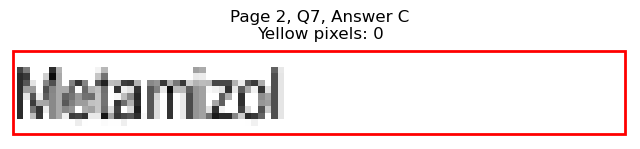

Page 2, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=394.3, y1=480.7
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 335
Page 2, Q7, D: Yellow percentage: 0.0%


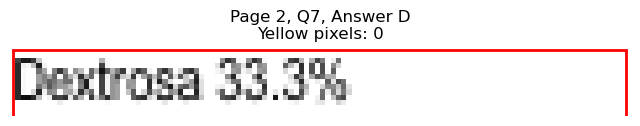


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=178.1, y1=543.8
Page 2, Q8, A: Yellow pixels: 1682
Page 2, Q8, A: Total non-white pixels: 2093
Page 2, Q8, A: Yellow percentage: 80.4%


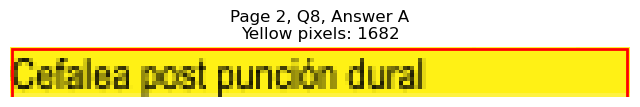

Page 2, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=155.1, y1=556.4
Page 2, Q8, B: Yellow pixels: 135
Page 2, Q8, B: Total non-white pixels: 585
Page 2, Q8, B: Yellow percentage: 23.1%


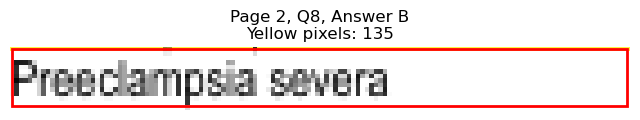

Page 2, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=412.7, y1=543.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 421
Page 2, Q8, C: Yellow percentage: 0.0%


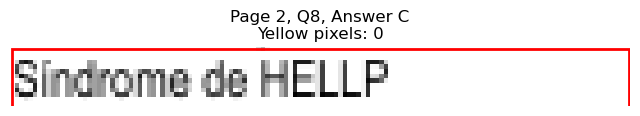

Page 2, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=403.7, y1=556.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 404
Page 2, Q8, D: Yellow percentage: 0.0%


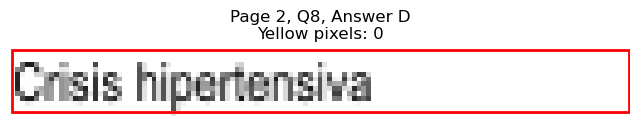


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=101.9, y1=619.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 179
Page 2, Q9, A: Yellow percentage: 0.0%


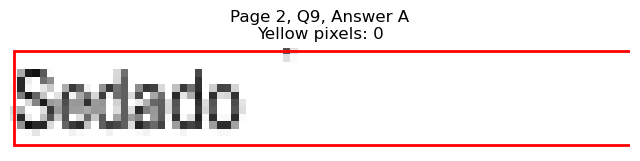

Page 2, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=135.0, y1=632.3
Page 2, Q9, B: Yellow pixels: 1150
Page 2, Q9, B: Total non-white pixels: 1652
Page 2, Q9, B: Yellow percentage: 69.6%


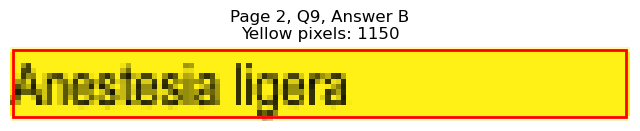

Page 2, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=402.8, y1=619.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 397
Page 2, Q9, C: Yellow percentage: 0.0%


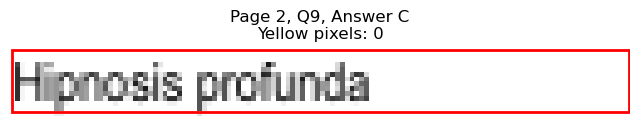

Page 2, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=402.3, y1=632.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 388
Page 2, Q9, D: Yellow percentage: 0.0%


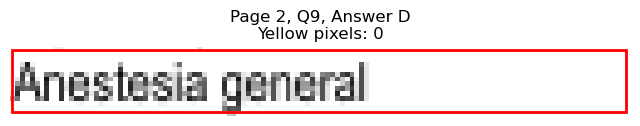


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=214.7, y1=682.7
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 749
Page 2, Q10, A: Yellow percentage: 0.0%


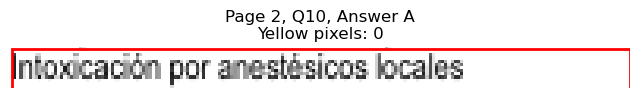

Page 2, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=193.7, y1=695.3
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 629
Page 2, Q10, B: Yellow percentage: 0.0%


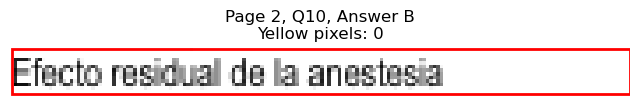

Page 2, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=408.9, y1=682.7
Page 2, Q10, C: Yellow pixels: 1
Page 2, Q10, C: Total non-white pixels: 557
Page 2, Q10, C: Yellow percentage: 0.2%


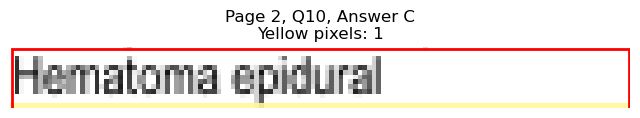

Page 2, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=437.3, y1=695.3
Page 2, Q10, D: Yellow pixels: 1511
Page 2, Q10, D: Total non-white pixels: 2254
Page 2, Q10, D: Yellow percentage: 67.0%


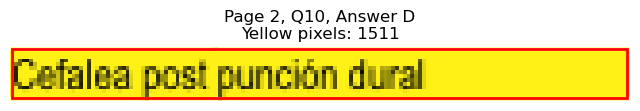


Page 2, Q10 - Selected Answer: D (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=154.6, y1=733.2
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 364
Page 2, Q11, A: Yellow percentage: 0.0%


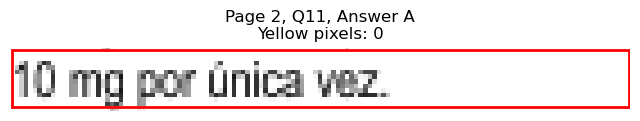

Page 2, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=152.5, y1=745.8
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 374
Page 2, Q11, B: Yellow percentage: 0.0%


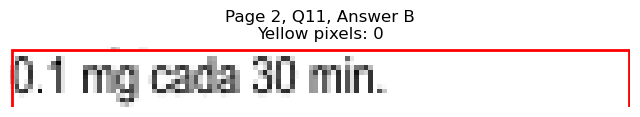

Page 2, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=407.3, y1=733.2
Page 2, Q11, C: Yellow pixels: 1458
Page 2, Q11, C: Total non-white pixels: 1834
Page 2, Q11, C: Yellow percentage: 79.5%


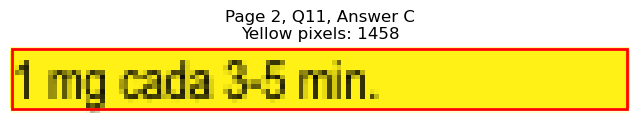

Page 2, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=407.8, y1=745.8
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 493
Page 2, Q11, D: Yellow percentage: 0.0%


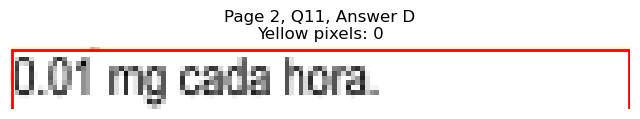


Page 2, Q11 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=103.5, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 187
Page 3, Q1, A: Yellow percentage: 0.0%


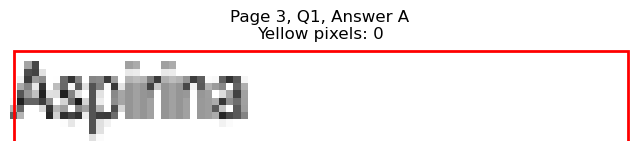

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=121.5, y1=127.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 273
Page 3, Q1, B: Yellow percentage: 0.0%


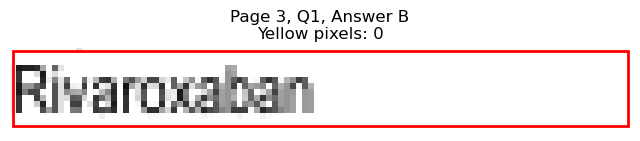

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=387.8, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 423
Page 3, Q1, C: Yellow percentage: 0.0%


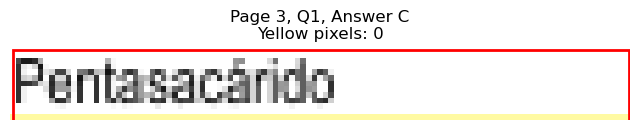

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=369.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 947
Page 3, Q1, D: Total non-white pixels: 1302
Page 3, Q1, D: Yellow percentage: 72.7%


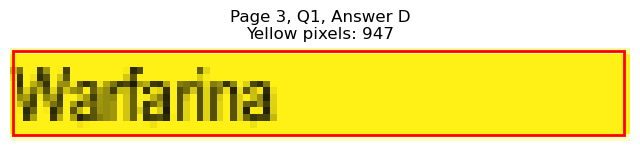


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=115.5, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 274
Page 3, Q2, A: Yellow percentage: 0.0%


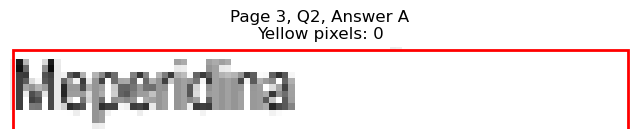

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=104.4, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 186
Page 3, Q2, B: Yellow percentage: 0.0%


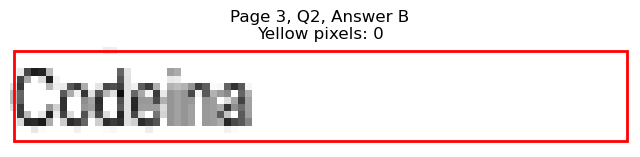

Page 3, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=391.3, y1=177.8
Page 3, Q2, C: Yellow pixels: 1228
Page 3, Q2, C: Total non-white pixels: 1495
Page 3, Q2, C: Yellow percentage: 82.1%


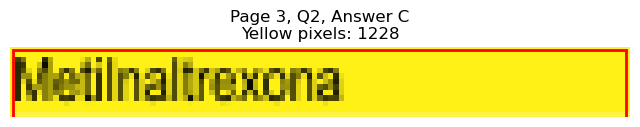

Page 3, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=384.7, y1=190.4
Page 3, Q2, D: Yellow pixels: 108
Page 3, Q2, D: Total non-white pixels: 401
Page 3, Q2, D: Yellow percentage: 26.9%


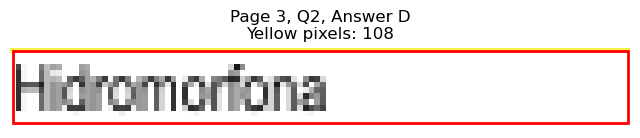


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=104.4, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 195
Page 3, Q3, A: Yellow percentage: 0.0%


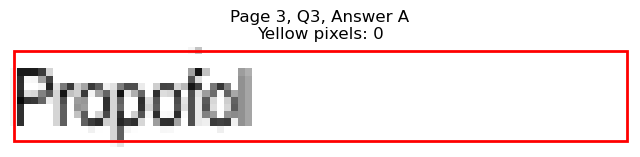

Page 3, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=114.4, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 249
Page 3, Q3, B: Yellow percentage: 0.0%


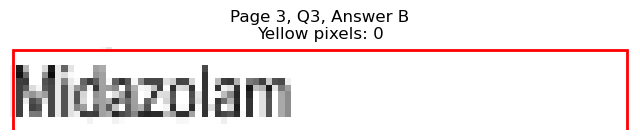

Page 3, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=383.2, y1=228.3
Page 3, Q3, C: Yellow pixels: 107
Page 3, Q3, C: Total non-white pixels: 407
Page 3, Q3, C: Yellow percentage: 26.3%


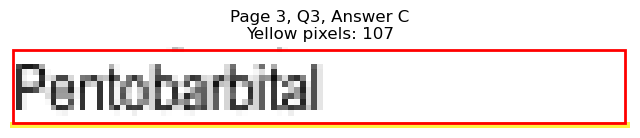

Page 3, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=402.8, y1=240.9
Page 3, Q3, D: Yellow pixels: 1325
Page 3, Q3, D: Total non-white pixels: 1638
Page 3, Q3, D: Yellow percentage: 80.9%


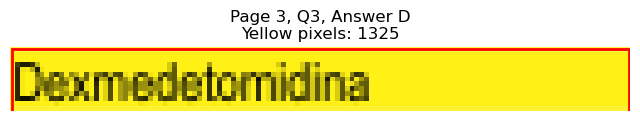


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=145.1, y1=304.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 365
Page 3, Q4, A: Yellow percentage: 0.0%


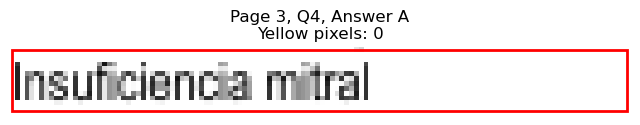

Page 3, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=174.1, y1=316.7
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 519
Page 3, Q4, B: Yellow percentage: 0.0%


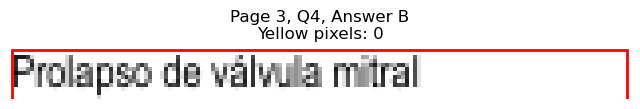

Page 3, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=398.8, y1=304.1
Page 3, Q4, C: Yellow pixels: 122
Page 3, Q4, C: Total non-white pixels: 484
Page 3, Q4, C: Yellow percentage: 25.2%


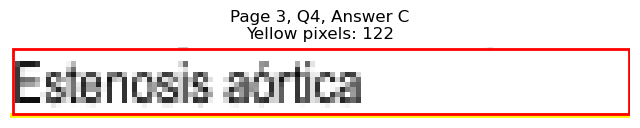

Page 3, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=393.8, y1=316.7
Page 3, Q4, D: Yellow pixels: 1255
Page 3, Q4, D: Total non-white pixels: 1521
Page 3, Q4, D: Yellow percentage: 82.5%


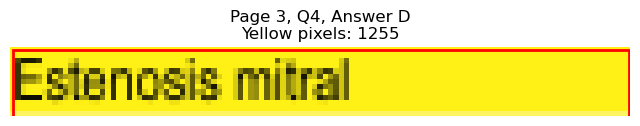


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=157.6, y1=379.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 457
Page 3, Q5, A: Yellow percentage: 0.0%


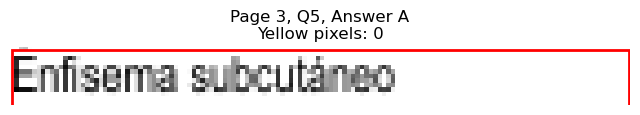

Page 3, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=125.4, y1=392.4
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 299
Page 3, Q5, B: Yellow percentage: 0.0%


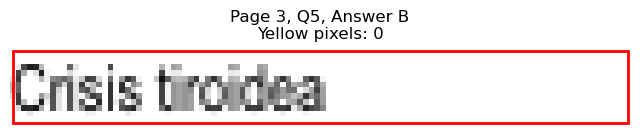

Page 3, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=410.8, y1=379.8
Page 3, Q5, C: Yellow pixels: 1379
Page 3, Q5, C: Total non-white pixels: 1742
Page 3, Q5, C: Yellow percentage: 79.2%


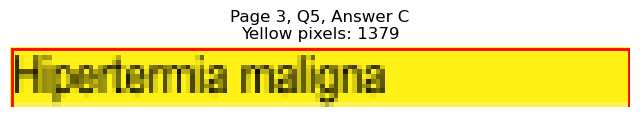

Page 3, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=426.3, y1=392.4
Page 3, Q5, D: Yellow pixels: 149
Page 3, Q5, D: Total non-white pixels: 645
Page 3, Q5, D: Yellow percentage: 23.1%


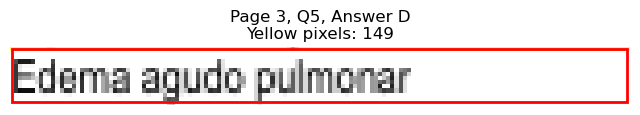


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=109.0, y1=430.3
Page 3, Q6, A: Yellow pixels: 939
Page 3, Q6, A: Total non-white pixels: 1274
Page 3, Q6, A: Yellow percentage: 73.7%


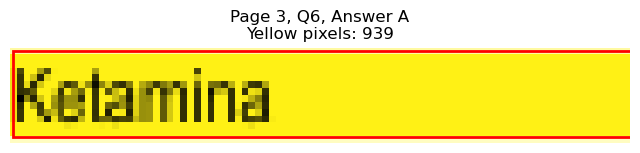

Page 3, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=107.9, y1=442.9
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 286
Page 3, Q6, B: Yellow percentage: 0.0%


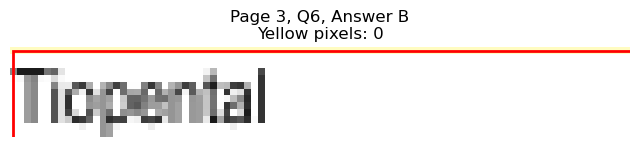

Page 3, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=363.7, y1=430.3
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 180
Page 3, Q6, C: Yellow percentage: 0.0%


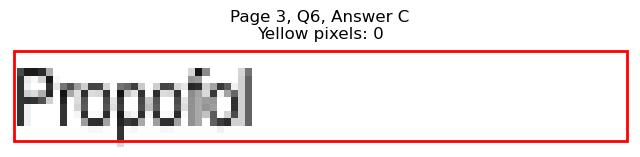

Page 3, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=370.6, y1=442.9
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 221
Page 3, Q6, D: Yellow percentage: 0.0%


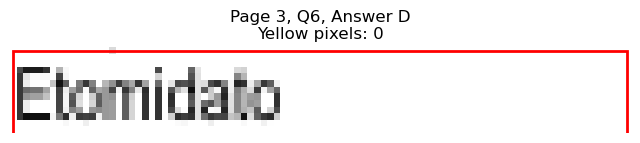


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=271.5, y1=493.4
Page 3, Q7, A: Yellow pixels: 8
Page 3, Q7, A: Total non-white pixels: 1051
Page 3, Q7, A: Yellow percentage: 0.8%


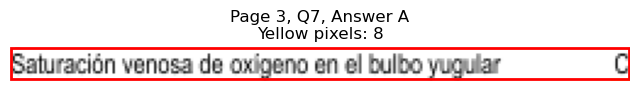

Page 3, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=194.2, y1=506.0
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 638
Page 3, Q7, B: Yellow percentage: 0.0%


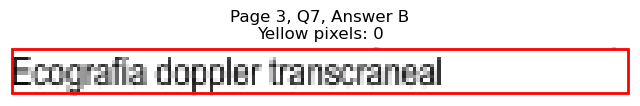

Page 3, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=417.8, y1=493.4
Page 3, Q7, C: Yellow pixels: 141
Page 3, Q7, C: Total non-white pixels: 604
Page 3, Q7, C: Yellow percentage: 23.3%


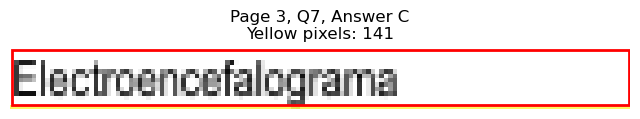

Page 3, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=404.3, y1=506.0
Page 3, Q7, D: Yellow pixels: 1367
Page 3, Q7, D: Total non-white pixels: 1664
Page 3, Q7, D: Yellow percentage: 82.2%


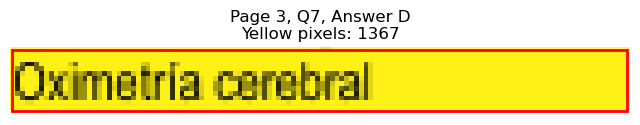


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=183.6, y1=556.4
Page 3, Q8, A: Yellow pixels: 1735
Page 3, Q8, A: Total non-white pixels: 2324
Page 3, Q8, A: Yellow percentage: 74.7%


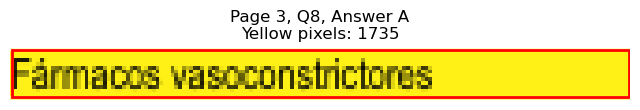

Page 3, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=210.8, y1=569.2
Page 3, Q8, B: Yellow pixels: 193
Page 3, Q8, B: Total non-white pixels: 926
Page 3, Q8, B: Yellow percentage: 20.8%


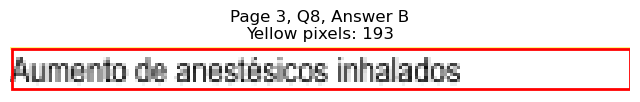

Page 3, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=422.3, y1=556.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 508
Page 3, Q8, C: Yellow percentage: 0.0%


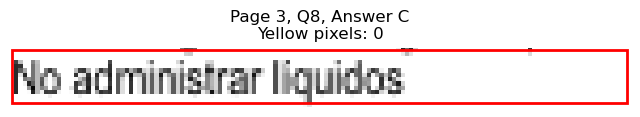

Page 3, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=441.4, y1=569.2
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 611
Page 3, Q8, D: Yellow percentage: 0.0%


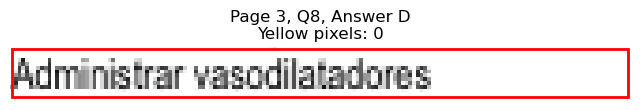


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=114.5, y1=619.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 227
Page 3, Q9, A: Yellow percentage: 0.0%


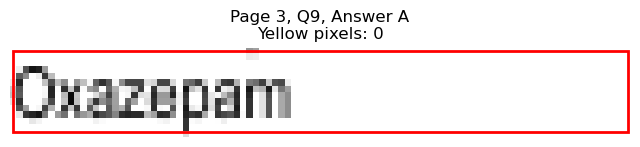

Page 3, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=109.0, y1=632.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 205
Page 3, Q9, B: Yellow percentage: 0.0%


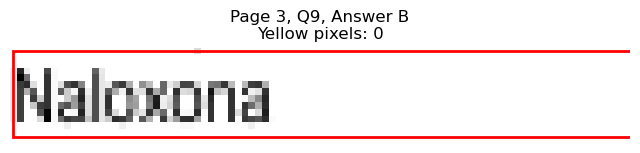

Page 3, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=374.7, y1=619.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 233
Page 3, Q9, C: Yellow percentage: 0.0%


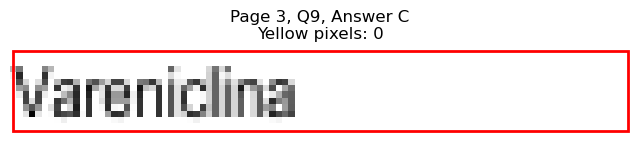

Page 3, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=370.1, y1=632.3
Page 3, Q9, D: Yellow pixels: 956
Page 3, Q9, D: Total non-white pixels: 1316
Page 3, Q9, D: Yellow percentage: 72.6%


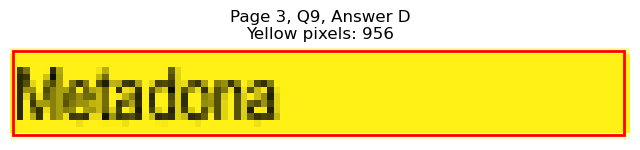


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=178.2, y1=682.7
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 547
Page 3, Q10, A: Yellow percentage: 0.0%


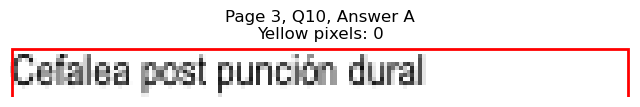

Page 3, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=245.8, y1=695.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 904
Page 3, Q10, B: Yellow percentage: 0.0%


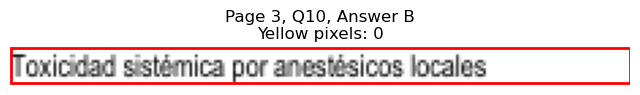

Page 3, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=422.9, y1=682.7
Page 3, Q10, C: Yellow pixels: 1540
Page 3, Q10, C: Total non-white pixels: 1898
Page 3, Q10, C: Yellow percentage: 81.1%


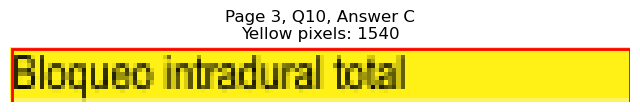

Page 3, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=405.8, y1=695.3
Page 3, Q10, D: Yellow pixels: 129
Page 3, Q10, D: Total non-white pixels: 526
Page 3, Q10, D: Yellow percentage: 24.5%


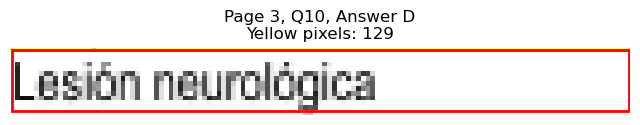


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=123.5, y1=745.8
Page 3, Q11, A: Yellow pixels: 1
Page 3, Q11, A: Total non-white pixels: 403
Page 3, Q11, A: Yellow percentage: 0.2%


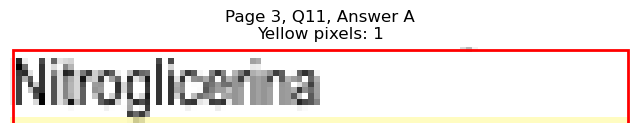

Page 3, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=150.5, y1=758.4
Page 3, Q11, B: Yellow pixels: 1414
Page 3, Q11, B: Total non-white pixels: 1862
Page 3, Q11, B: Yellow percentage: 75.9%


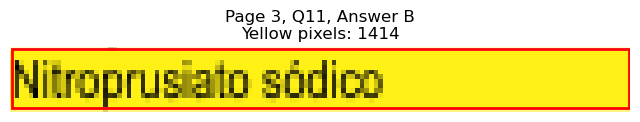

Page 3, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=435.4, y1=745.8
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 573
Page 3, Q11, C: Yellow percentage: 0.0%


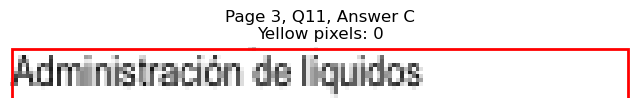

Page 3, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=419.8, y1=758.4
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 464
Page 3, Q11, D: Yellow percentage: 0.0%


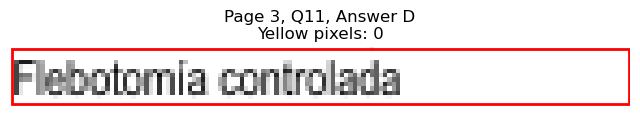


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=126.0, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 291
Page 4, Q1, A: Yellow percentage: 0.0%


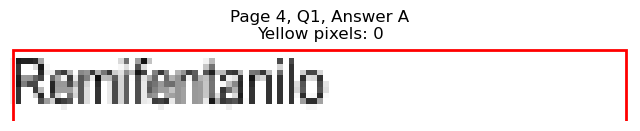

Page 4, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=107.9, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 178
Page 4, Q1, B: Yellow percentage: 0.0%


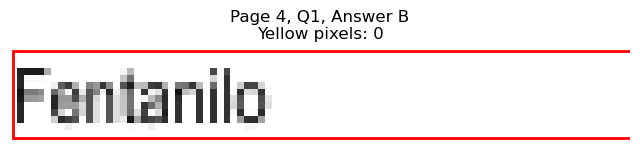

Page 4, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=363.8, y1=114.7
Page 4, Q1, C: Yellow pixels: 993
Page 4, Q1, C: Total non-white pixels: 1131
Page 4, Q1, C: Yellow percentage: 87.8%


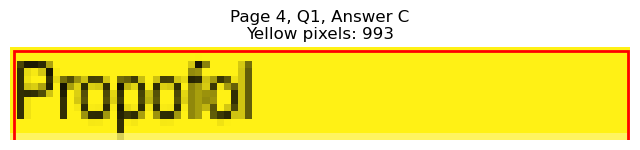

Page 4, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=378.2, y1=127.3
Page 4, Q1, D: Yellow pixels: 102
Page 4, Q1, D: Total non-white pixels: 357
Page 4, Q1, D: Yellow percentage: 28.6%


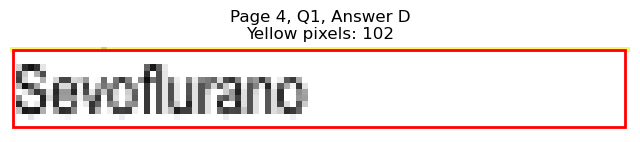


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=78.4, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 97
Page 4, Q2, A: Yellow percentage: 0.0%


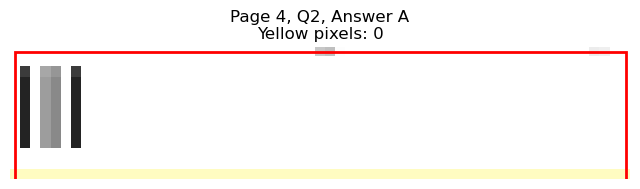

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=79.3, y1=190.4
Page 4, Q2, B: Yellow pixels: 713
Page 4, Q2, B: Total non-white pixels: 868
Page 4, Q2, B: Yellow percentage: 82.1%


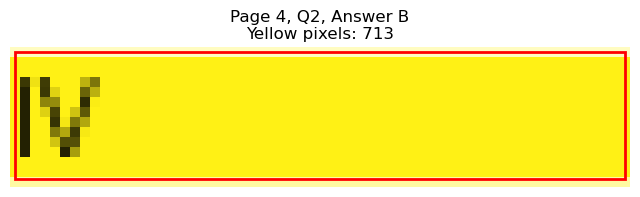

Page 4, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 70
Page 4, Q2, C: Yellow percentage: 0.0%


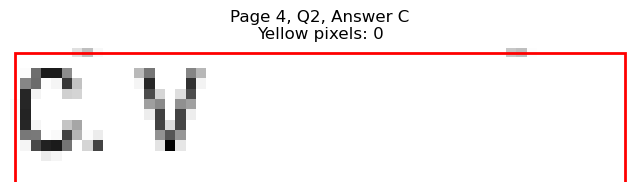

Page 4, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=324.4, y1=190.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 72
Page 4, Q2, D: Yellow percentage: 0.0%


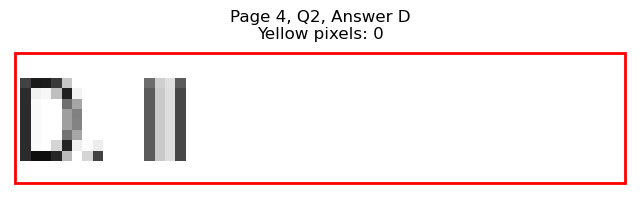


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=121.0, y1=228.3
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 252
Page 4, Q3, A: Yellow percentage: 0.0%


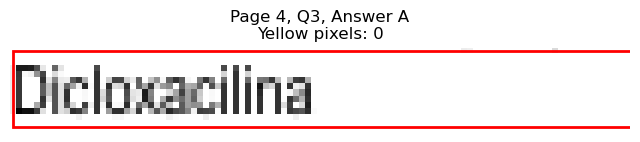

Page 4, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=109.0, y1=240.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 189
Page 4, Q3, B: Yellow percentage: 0.0%


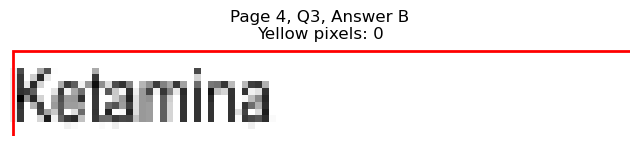

Page 4, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=375.7, y1=228.3
Page 4, Q3, C: Yellow pixels: 962
Page 4, Q3, C: Total non-white pixels: 1386
Page 4, Q3, C: Yellow percentage: 69.4%


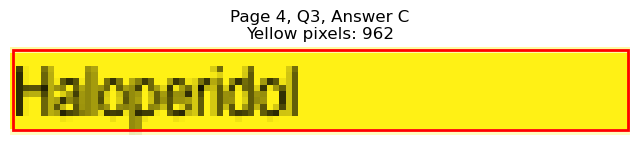

Page 4, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=380.2, y1=240.9
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 395
Page 4, Q3, D: Yellow percentage: 0.0%


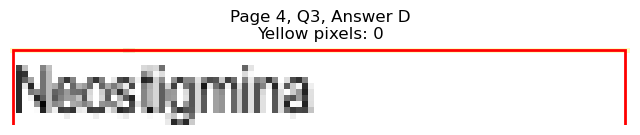


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=123.0, y1=278.7
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 263
Page 4, Q4, A: Yellow percentage: 0.0%


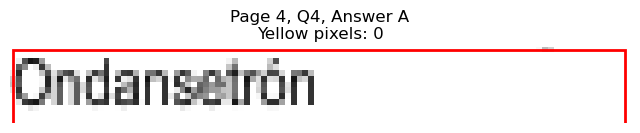

Page 4, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=131.5, y1=291.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 324
Page 4, Q4, B: Yellow percentage: 0.0%


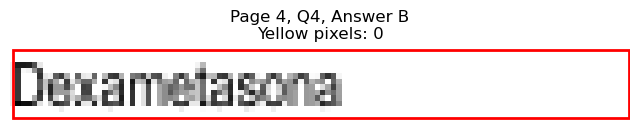

Page 4, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=386.7, y1=278.7
Page 4, Q4, C: Yellow pixels: 1204
Page 4, Q4, C: Total non-white pixels: 1430
Page 4, Q4, C: Yellow percentage: 84.2%


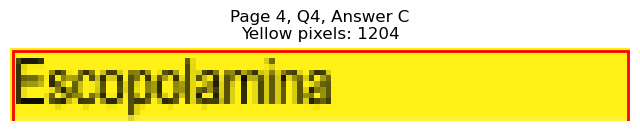

Page 4, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=394.3, y1=291.5
Page 4, Q4, D: Yellow pixels: 118
Page 4, Q4, D: Total non-white pixels: 484
Page 4, Q4, D: Yellow percentage: 24.4%


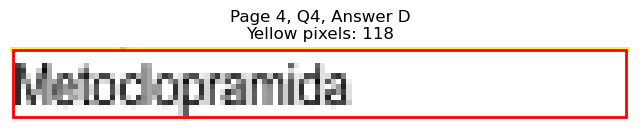


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=112.9, y1=329.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 214
Page 4, Q5, A: Yellow percentage: 0.0%


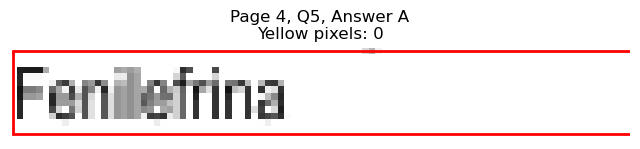

Page 4, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=127.5, y1=341.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 320
Page 4, Q5, B: Yellow percentage: 0.0%


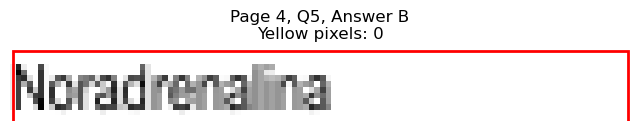

Page 4, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=380.2, y1=329.3
Page 4, Q5, C: Yellow pixels: 104
Page 4, Q5, C: Total non-white pixels: 383
Page 4, Q5, C: Yellow percentage: 27.2%


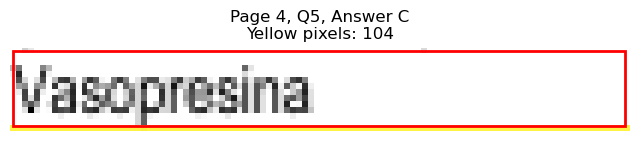

Page 4, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=378.7, y1=341.9
Page 4, Q5, D: Yellow pixels: 1113
Page 4, Q5, D: Total non-white pixels: 1326
Page 4, Q5, D: Yellow percentage: 83.9%


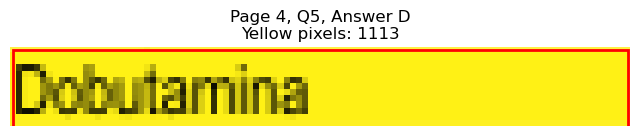


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=238.4, y1=405.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 1091
Page 4, Q6, A: Yellow percentage: 0.0%


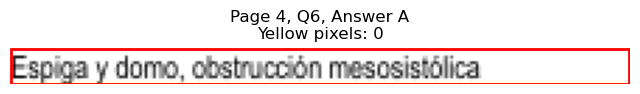

Page 4, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=279.0, y1=417.6
Page 4, Q6, B: Yellow pixels: 2599
Page 4, Q6, B: Total non-white pixels: 3668
Page 4, Q6, B: Yellow percentage: 70.9%


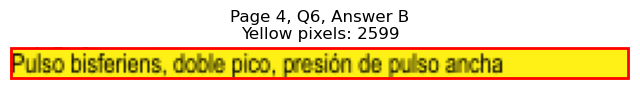

Page 4, Q6 - C: Detected box: x0=68.8, y0=417.6, x1=299.6, y1=430.3
Page 4, Q6, C: Yellow pixels: 282
Page 4, Q6, C: Total non-white pixels: 1414
Page 4, Q6, C: Yellow percentage: 19.9%


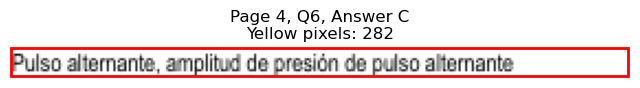

Page 4, Q6 - D: Detected box: x0=68.8, y0=430.2, x1=231.8, y1=442.9
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 782
Page 4, Q6, D: Yellow percentage: 0.0%


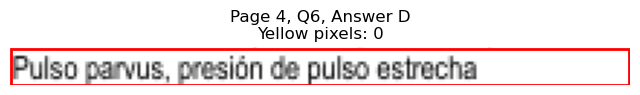


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=203.8, y1=480.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 679
Page 4, Q7, A: Yellow percentage: 0.0%


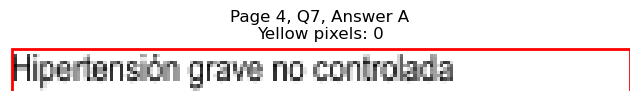

Page 4, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=166.6, y1=493.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 471
Page 4, Q7, B: Yellow percentage: 0.0%


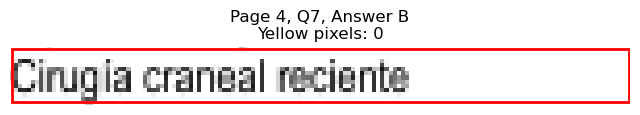

Page 4, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=403.4, y1=480.7
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 387
Page 4, Q7, C: Yellow percentage: 0.0%


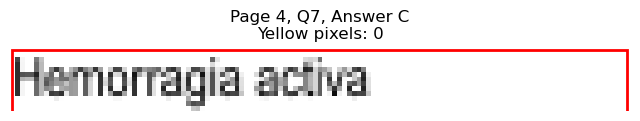

Page 4, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=371.2, y1=493.4
Page 4, Q7, D: Yellow pixels: 966
Page 4, Q7, D: Total non-white pixels: 1330
Page 4, Q7, D: Yellow percentage: 72.6%


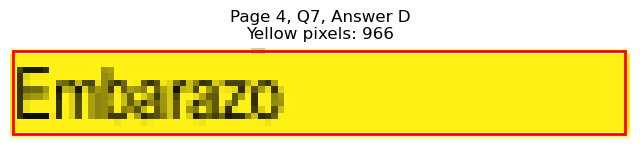


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=142.6, y1=543.8
Page 4, Q8, A: Yellow pixels: 1297
Page 4, Q8, A: Total non-white pixels: 1625
Page 4, Q8, A: Yellow percentage: 79.8%


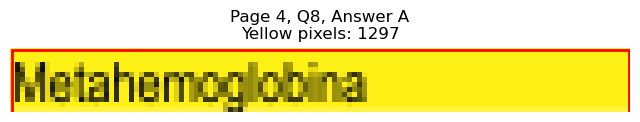

Page 4, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=117.4, y1=556.4
Page 4, Q8, B: Yellow pixels: 96
Page 4, Q8, B: Total non-white pixels: 366
Page 4, Q8, B: Yellow percentage: 26.2%


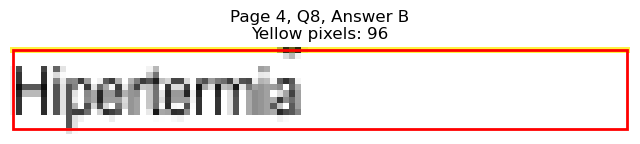

Page 4, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=363.7, y1=543.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 185
Page 4, Q8, C: Yellow percentage: 0.0%


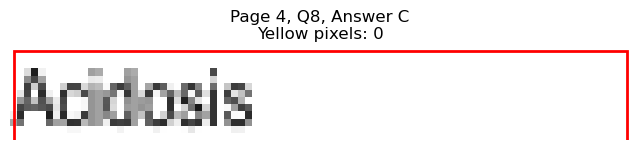

Page 4, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=414.8, y1=556.4
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 419
Page 4, Q8, D: Yellow percentage: 0.0%


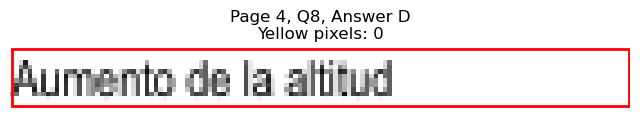


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=272.9, y1=607.0
Page 4, Q9, A: Yellow pixels: 1954
Page 4, Q9, A: Total non-white pixels: 2816
Page 4, Q9, A: Yellow percentage: 69.4%


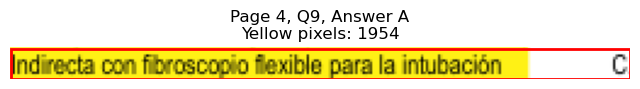

Page 4, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=213.9, y1=619.6
Page 4, Q9, B: Yellow pixels: 192
Page 4, Q9, B: Total non-white pixels: 894
Page 4, Q9, B: Yellow percentage: 21.5%


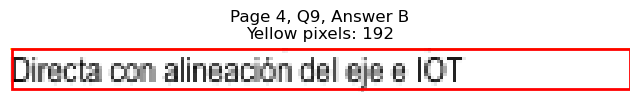

Page 4, Q9 - C: Detected box: x0=327.5, y0=594.3, x1=419.8, y1=607.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 445
Page 4, Q9, C: Yellow percentage: 0.0%


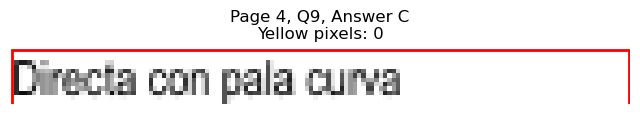

Page 4, Q9 - D: Detected box: x0=327.5, y0=606.9, x1=485.0, y1=619.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 766
Page 4, Q9, D: Yellow percentage: 0.0%


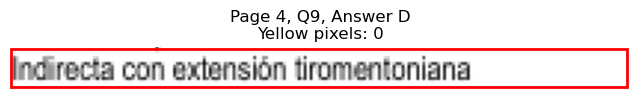


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=56.6, y0=644.9, x1=65.2, y1=657.5
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 62
Page 4, Q10, A: Yellow percentage: 0.0%


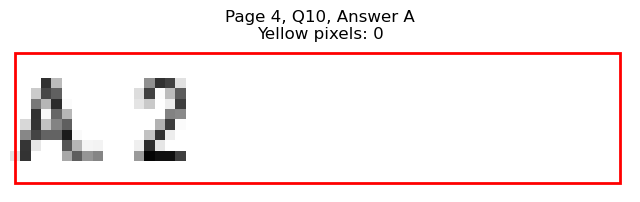

Page 4, Q10 - B: Detected box: x0=56.6, y0=657.5, x1=65.2, y1=670.1
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 60
Page 4, Q10, B: Yellow percentage: 0.0%


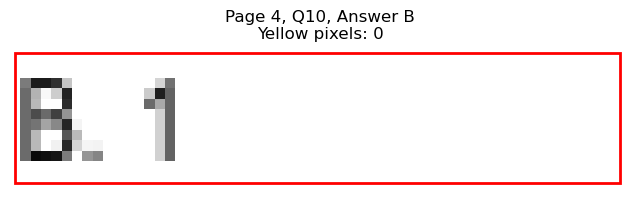

Page 4, Q10 - C: Detected box: x0=315.4, y0=644.9, x1=324.4, y1=657.5
Page 4, Q10, C: Yellow pixels: 735
Page 4, Q10, C: Total non-white pixels: 840
Page 4, Q10, C: Yellow percentage: 87.5%


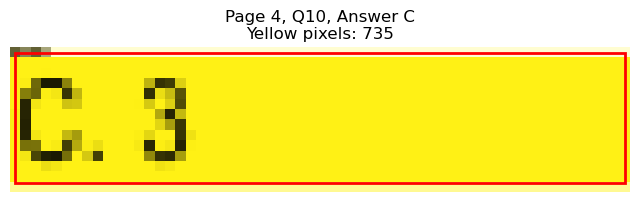

Page 4, Q10 - D: Detected box: x0=315.4, y0=657.5, x1=324.4, y1=670.1
Page 4, Q10, D: Yellow pixels: 60
Page 4, Q10, D: Total non-white pixels: 129
Page 4, Q10, D: Yellow percentage: 46.5%


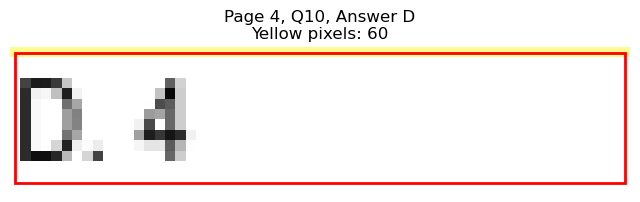


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=188.2, y1=708.0
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 626
Page 4, Q11, A: Yellow percentage: 0.0%


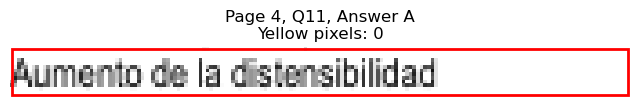

Page 4, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=115.9, y1=720.6
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 233
Page 4, Q11, B: Yellow percentage: 0.0%


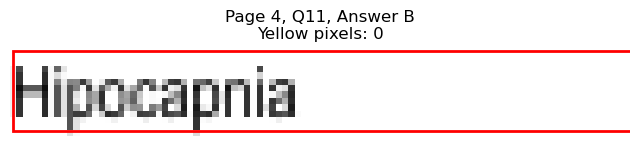

Page 4, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=480.1, y1=708.0
Page 4, Q11, C: Yellow pixels: 204
Page 4, Q11, C: Total non-white pixels: 1154
Page 4, Q11, C: Yellow percentage: 17.7%


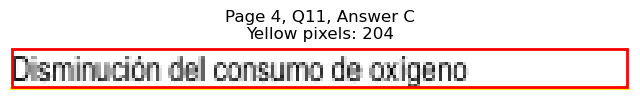

Page 4, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=406.9, y1=720.6
Page 4, Q11, D: Yellow pixels: 1410
Page 4, Q11, D: Total non-white pixels: 1820
Page 4, Q11, D: Yellow percentage: 77.5%


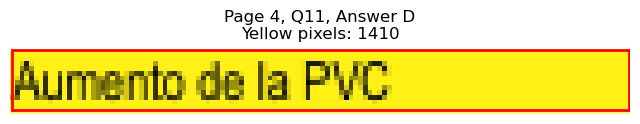


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 12 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=109.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 203
Page 5, Q1, A: Yellow percentage: 0.0%


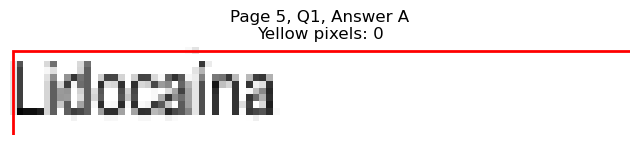

Page 5, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=120.5, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 279
Page 5, Q1, B: Yellow percentage: 0.0%


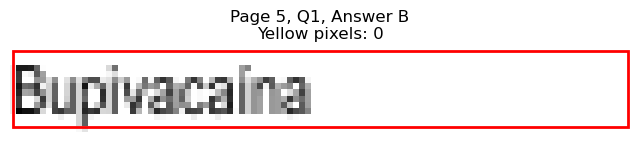

Page 5, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=380.2, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 372
Page 5, Q1, C: Yellow percentage: 0.0%


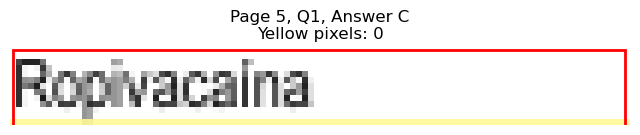

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=373.1, y1=127.3
Page 5, Q1, D: Yellow pixels: 1001
Page 5, Q1, D: Total non-white pixels: 1358
Page 5, Q1, D: Yellow percentage: 73.7%


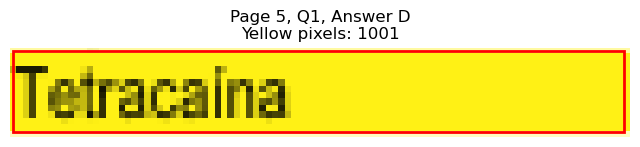


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=215.8, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 705
Page 5, Q2, A: Yellow percentage: 0.0%


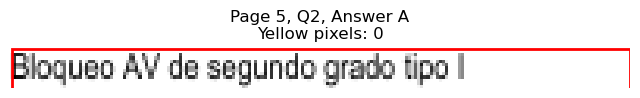

Page 5, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=134.5, y1=190.4
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 336
Page 5, Q2, B: Yellow percentage: 0.0%


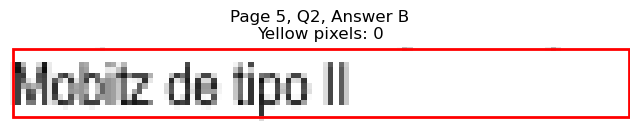

Page 5, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=441.4, y1=177.8
Page 5, Q2, C: Yellow pixels: 1733
Page 5, Q2, C: Total non-white pixels: 2145
Page 5, Q2, C: Yellow percentage: 80.8%


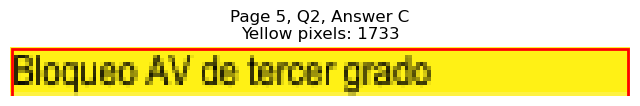

Page 5, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=443.9, y1=190.4
Page 5, Q2, D: Yellow pixels: 165
Page 5, Q2, D: Total non-white pixels: 720
Page 5, Q2, D: Yellow percentage: 22.9%


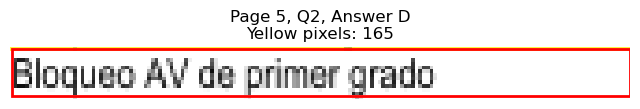


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=122.5, y1=228.3
Page 5, Q3, A: Yellow pixels: 1047
Page 5, Q3, A: Total non-white pixels: 1470
Page 5, Q3, A: Yellow percentage: 71.2%


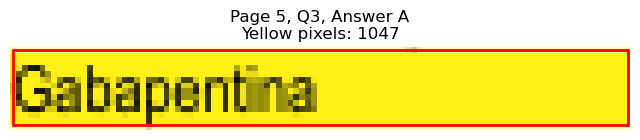

Page 5, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=109.0, y1=240.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 280
Page 5, Q3, B: Yellow percentage: 0.0%


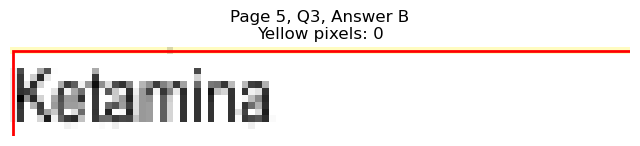

Page 5, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=380.7, y1=228.3
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 260
Page 5, Q3, C: Yellow percentage: 0.0%


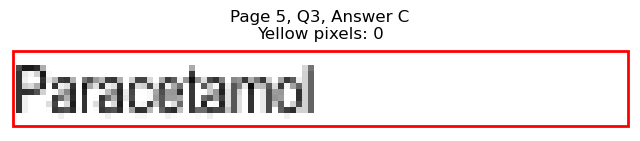

Page 5, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=369.7, y1=240.9
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 219
Page 5, Q3, D: Yellow percentage: 0.0%


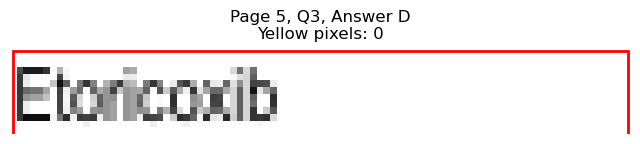


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=191.2, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 664
Page 5, Q4, A: Yellow percentage: 0.0%


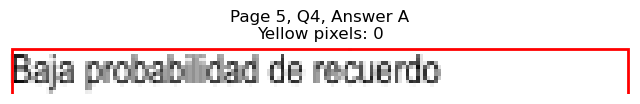

Page 5, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=143.5, y1=291.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 394
Page 5, Q4, B: Yellow percentage: 0.0%


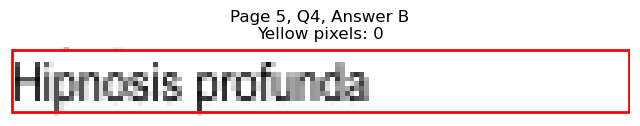

Page 5, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=368.7, y1=278.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 219
Page 5, Q4, C: Yellow percentage: 0.0%


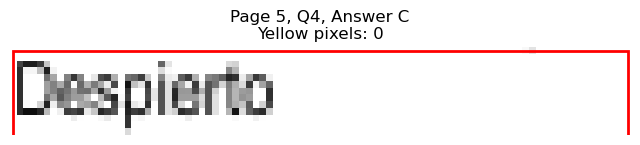

Page 5, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=392.2, y1=291.5
Page 5, Q4, D: Yellow pixels: 1260
Page 5, Q4, D: Total non-white pixels: 1624
Page 5, Q4, D: Yellow percentage: 77.6%


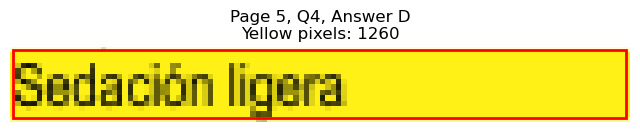


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=106.9, y1=329.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 172
Page 5, Q5, A: Yellow percentage: 0.0%


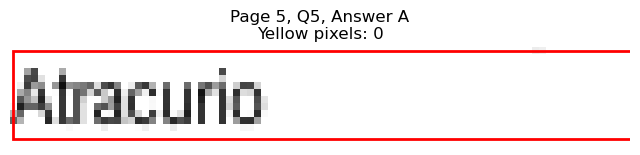

Page 5, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=112.0, y1=341.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 191
Page 5, Q5, B: Yellow percentage: 0.0%


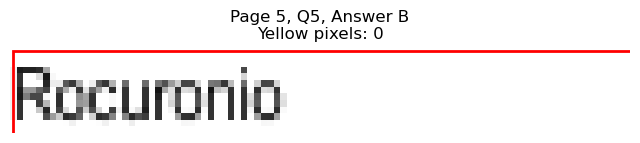

Page 5, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=370.7, y1=329.3
Page 5, Q5, C: Yellow pixels: 94
Page 5, Q5, C: Total non-white pixels: 308
Page 5, Q5, C: Yellow percentage: 30.5%


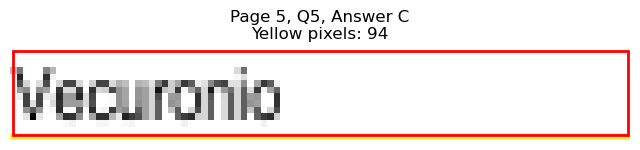

Page 5, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=384.7, y1=341.9
Page 5, Q5, D: Yellow pixels: 1190
Page 5, Q5, D: Total non-white pixels: 1404
Page 5, Q5, D: Yellow percentage: 84.8%


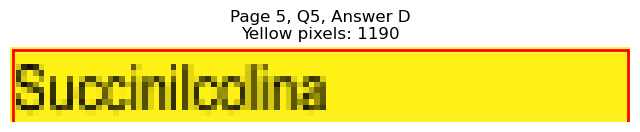


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=145.0, y1=392.4
Page 5, Q6, A: Yellow pixels: 127
Page 5, Q6, A: Total non-white pixels: 538
Page 5, Q6, A: Yellow percentage: 23.6%


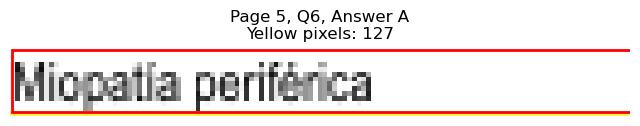

Page 5, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=163.2, y1=405.0
Page 5, Q6, B: Yellow pixels: 1542
Page 5, Q6, B: Total non-white pixels: 1898
Page 5, Q6, B: Yellow percentage: 81.2%


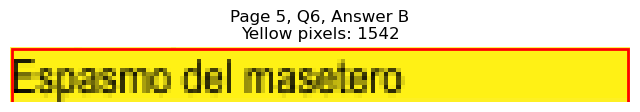

Page 5, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=373.1, y1=392.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 230
Page 5, Q6, C: Yellow percentage: 0.0%


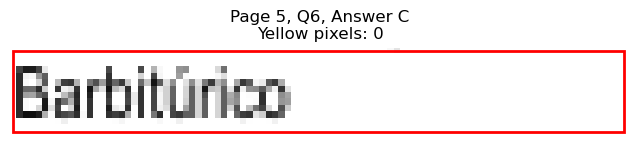

Page 5, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=384.7, y1=405.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 289
Page 5, Q6, D: Yellow percentage: 0.0%


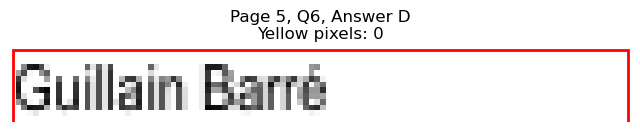


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=162.1, y1=468.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 422
Page 5, Q7, A: Yellow percentage: 0.0%


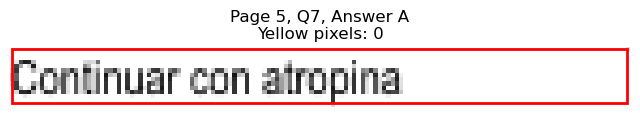

Page 5, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=175.6, y1=480.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 541
Page 5, Q7, B: Yellow percentage: 0.0%


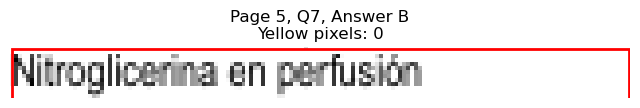

Page 5, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=423.3, y1=468.1
Page 5, Q7, C: Yellow pixels: 1538
Page 5, Q7, C: Total non-white pixels: 2058
Page 5, Q7, C: Yellow percentage: 74.7%


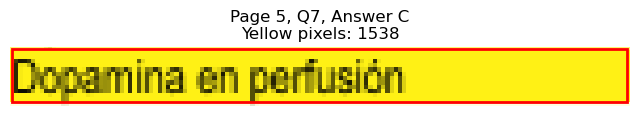

Page 5, Q7 - D: Detected box: x0=337.8, y0=468.1, x1=375.4, y1=480.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 269
Page 5, Q7, D: Yellow percentage: 0.0%


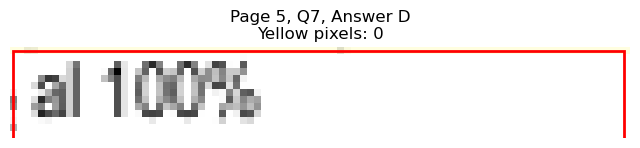


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=109.9, y1=518.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 208
Page 5, Q8, A: Yellow percentage: 0.0%


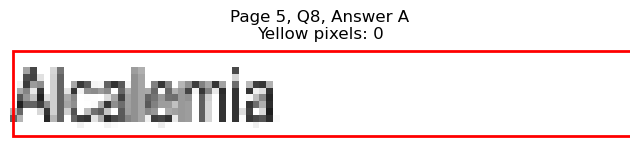

Page 5, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=115.9, y1=531.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 233
Page 5, Q8, B: Yellow percentage: 0.0%


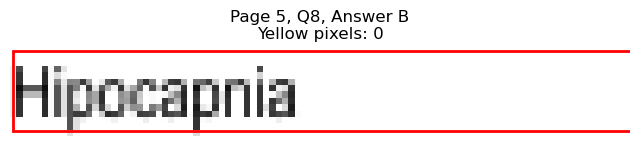

Page 5, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=407.8, y1=518.6
Page 5, Q8, C: Yellow pixels: 131
Page 5, Q8, C: Total non-white pixels: 537
Page 5, Q8, C: Yellow percentage: 24.4%


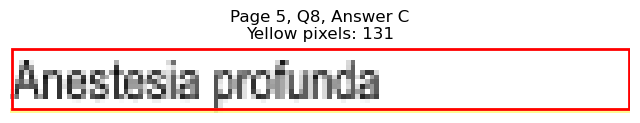

Page 5, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=351.7, y1=531.2
Page 5, Q8, D: Yellow pixels: 879
Page 5, Q8, D: Total non-white pixels: 1050
Page 5, Q8, D: Yellow percentage: 83.7%


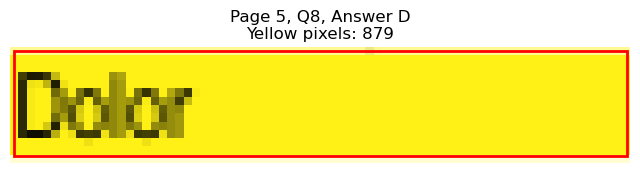


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=104.4, y1=569.2
Page 5, Q9, A: Yellow pixels: 87
Page 5, Q9, A: Total non-white pixels: 278
Page 5, Q9, A: Yellow percentage: 31.3%


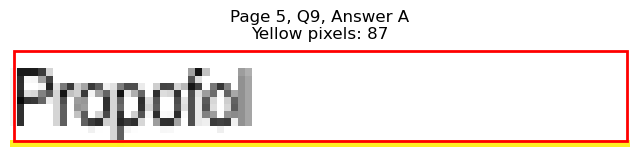

Page 5, Q9 - B: Detected box: x0=68.3, y0=228.3, x1=109.0, y1=240.9
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 280
Page 5, Q9, B: Yellow percentage: 0.0%


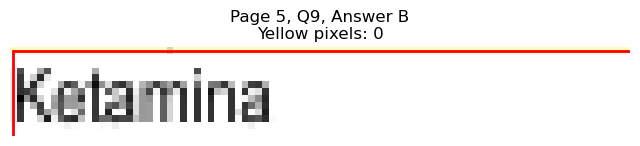

Page 5, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=398.9, y1=569.2
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 380
Page 5, Q9, C: Yellow percentage: 0.0%


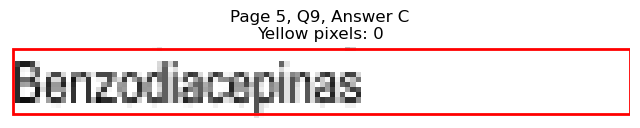

Page 5, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=377.7, y1=581.8
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 253
Page 5, Q9, D: Yellow percentage: 0.0%


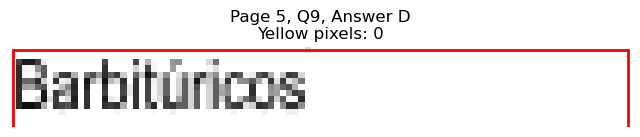


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=619.6, x1=90.4, y1=632.3
Page 5, Q10, A: Yellow pixels: 794
Page 5, Q10, A: Total non-white pixels: 1022
Page 5, Q10, A: Yellow percentage: 77.7%


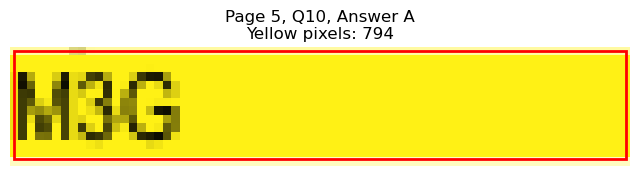

Page 5, Q10 - B: Detected box: x0=68.3, y0=632.2, x1=90.4, y1=644.9
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 201
Page 5, Q10, B: Yellow percentage: 0.0%


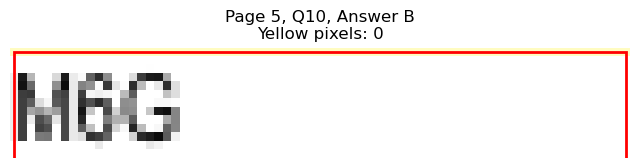

Page 5, Q10 - C: Detected box: x0=327.5, y0=619.6, x1=349.6, y1=632.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 123
Page 5, Q10, C: Yellow percentage: 0.0%


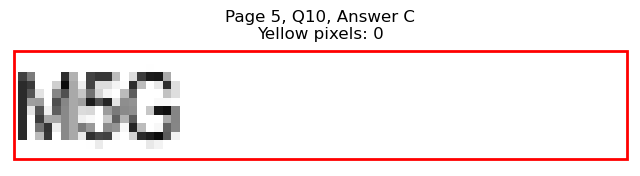

Page 5, Q10 - D: Detected box: x0=327.5, y0=632.2, x1=349.6, y1=644.9
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 112
Page 5, Q10, D: Yellow percentage: 0.0%


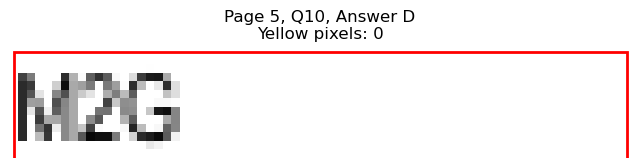


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=670.1, x1=189.6, y1=682.7
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 596
Page 5, Q11, A: Yellow percentage: 0.0%


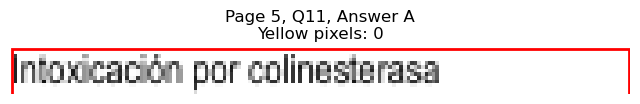

Page 5, Q11 - B: Detected box: x0=68.3, y0=682.7, x1=136.0, y1=695.3
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 370
Page 5, Q11, B: Yellow percentage: 0.0%


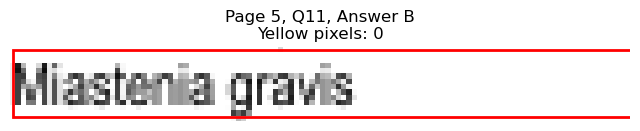

Page 5, Q11 - C: Detected box: x0=327.5, y0=670.1, x1=464.1, y1=682.7
Page 5, Q11, C: Yellow pixels: 4
Page 5, Q11, C: Total non-white pixels: 872
Page 5, Q11, C: Yellow percentage: 0.5%


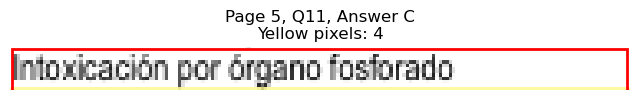

Page 5, Q11 - D: Detected box: x0=327.5, y0=682.7, x1=382.3, y1=695.3
Page 5, Q11, D: Yellow pixels: 1064
Page 5, Q11, D: Total non-white pixels: 1484
Page 5, Q11, D: Yellow percentage: 71.7%


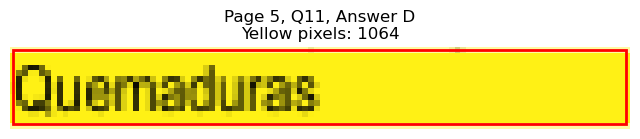


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)




Page 5, Q12 - A: Detected box: x0=68.3, y0=720.6, x1=184.7, y1=733.2
Page 5, Q12, A: Yellow pixels: 1688
Page 5, Q12, A: Total non-white pixels: 2338
Page 5, Q12, A: Yellow percentage: 72.2%


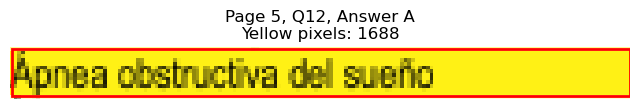

Page 5, Q12 - B: Detected box: x0=68.3, y0=733.2, x1=185.0, y1=745.8
Page 5, Q12, B: Yellow pixels: 0
Page 5, Q12, B: Total non-white pixels: 707
Page 5, Q12, B: Yellow percentage: 0.0%


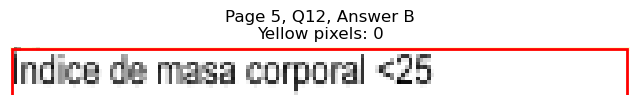

Page 5, Q12 - C: Detected box: x0=327.5, y0=720.6, x1=381.2, y1=733.2
Page 5, Q12, C: Yellow pixels: 0
Page 5, Q12, C: Total non-white pixels: 286
Page 5, Q12, C: Yellow percentage: 0.0%


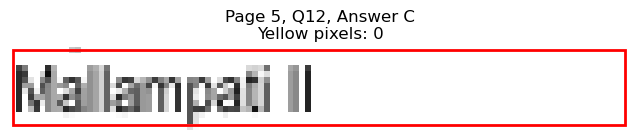

Page 5, Q12 - D: Detected box: x0=327.5, y0=733.2, x1=451.9, y1=745.8
Page 5, Q12, D: Yellow pixels: 0
Page 5, Q12, D: Total non-white pixels: 644
Page 5, Q12, D: Yellow percentage: 0.0%


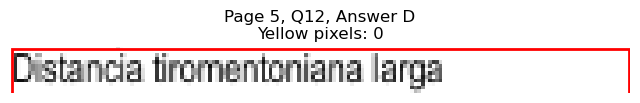


Page 5, Q12 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=109.0, y1=114.7
Page 6, Q1, A: Yellow pixels: 1030
Page 6, Q1, A: Total non-white pixels: 1183
Page 6, Q1, A: Yellow percentage: 87.1%


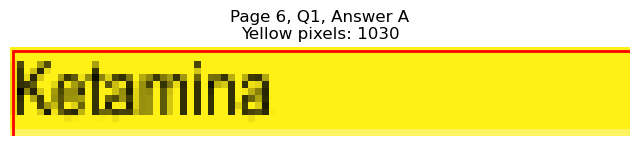

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=100.9, y1=127.3
Page 6, Q1, B: Yellow pixels: 83
Page 6, Q1, B: Total non-white pixels: 243
Page 6, Q1, B: Yellow percentage: 34.2%


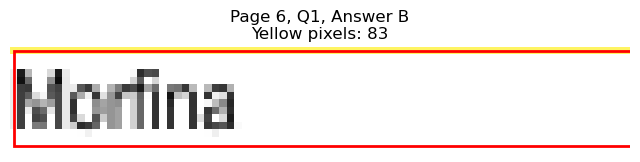

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=368.7, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 210
Page 6, Q1, C: Yellow percentage: 0.0%


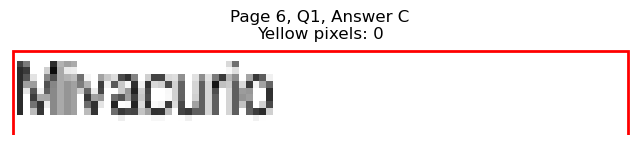

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=366.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 184
Page 6, Q1, D: Yellow percentage: 0.0%


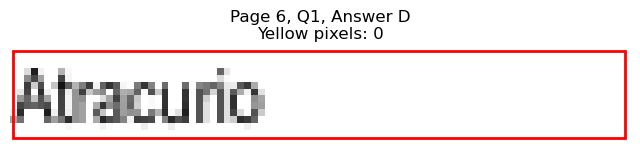


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=184.1, y1=177.8
Page 6, Q2, A: Yellow pixels: 1740
Page 6, Q2, A: Total non-white pixels: 2171
Page 6, Q2, A: Yellow percentage: 80.1%


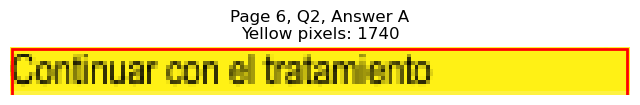

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=176.7, y1=190.4
Page 6, Q2, B: Yellow pixels: 159
Page 6, Q2, B: Total non-white pixels: 693
Page 6, Q2, B: Yellow percentage: 22.9%


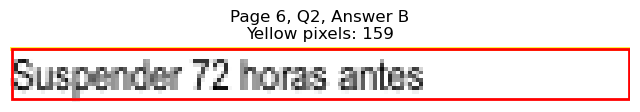

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=464.0, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 667
Page 6, Q2, C: Yellow percentage: 0.0%


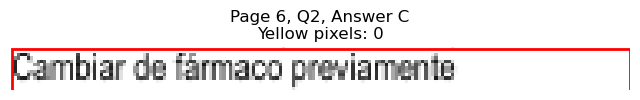

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=475.1, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 714
Page 6, Q2, D: Yellow percentage: 0.0%


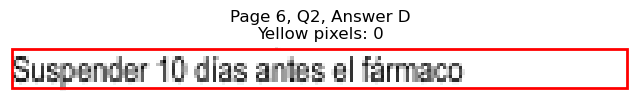


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=115.9, y1=228.3
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 189
Page 6, Q3, A: Yellow percentage: 0.0%


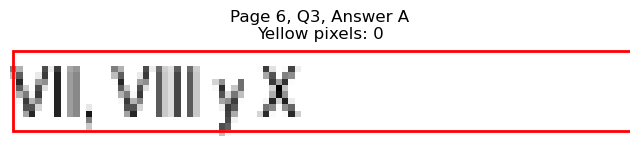

Page 6, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=115.9, y1=240.9
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 191
Page 6, Q3, B: Yellow percentage: 0.0%


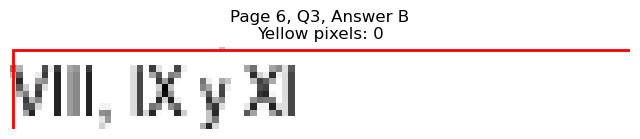

Page 6, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=369.2, y1=228.3
Page 6, Q3, C: Yellow pixels: 1006
Page 6, Q3, C: Total non-white pixels: 1302
Page 6, Q3, C: Yellow percentage: 77.3%


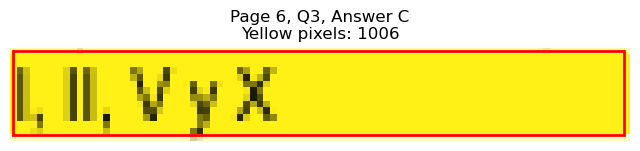

Page 6, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=388.7, y1=240.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 345
Page 6, Q3, D: Yellow percentage: 0.0%


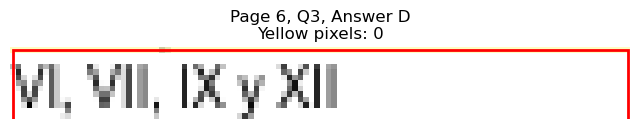


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=120.6, y1=291.5
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 243
Page 6, Q4, A: Yellow percentage: 0.0%


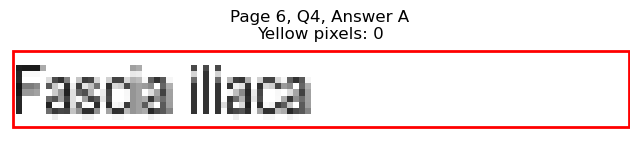

Page 6, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=111.4, y1=304.1
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 228
Page 6, Q4, B: Yellow percentage: 0.0%


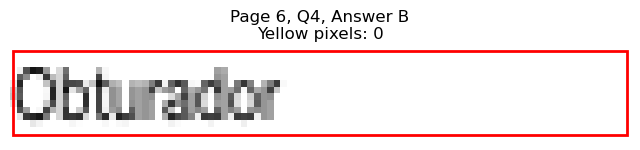

Page 6, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=399.8, y1=291.5
Page 6, Q4, C: Yellow pixels: 1327
Page 6, Q4, C: Total non-white pixels: 1722
Page 6, Q4, C: Yellow percentage: 77.1%


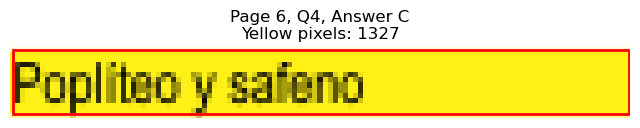

Page 6, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=423.8, y1=304.1
Page 6, Q4, D: Yellow pixels: 146
Page 6, Q4, D: Total non-white pixels: 633
Page 6, Q4, D: Yellow percentage: 23.1%


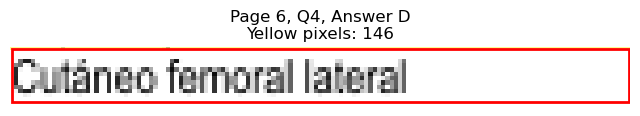


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=131.5, y1=341.9
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 326
Page 6, Q5, A: Yellow percentage: 0.0%


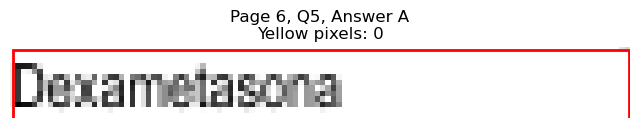

Page 6, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=135.0, y1=354.6
Page 6, Q5, B: Yellow pixels: 1250
Page 6, Q5, B: Total non-white pixels: 1652
Page 6, Q5, B: Yellow percentage: 75.7%


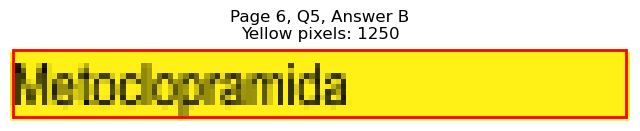

Page 6, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=374.7, y1=341.9
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 257
Page 6, Q5, C: Yellow percentage: 0.0%


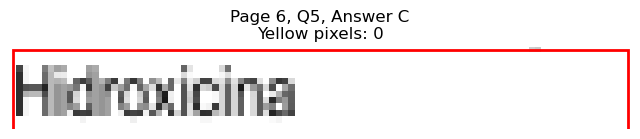

Page 6, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=382.4, y1=354.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 261
Page 6, Q5, D: Yellow percentage: 0.0%


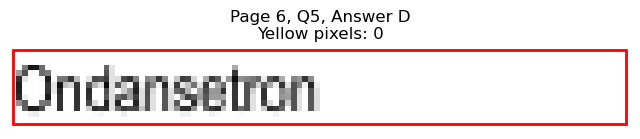


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=131.5, y1=392.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 294
Page 6, Q6, A: Yellow percentage: 0.0%


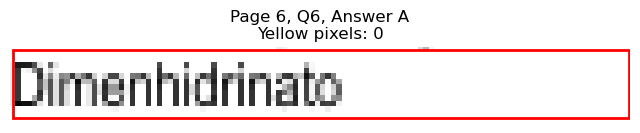

Page 6, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=112.0, y1=405.0
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 233
Page 6, Q6, B: Yellow percentage: 0.0%


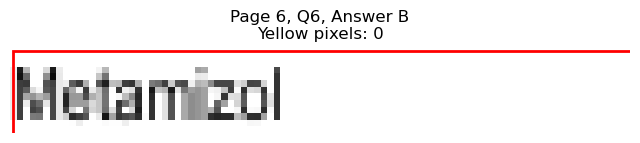

Page 6, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=367.6, y1=392.4
Page 6, Q6, C: Yellow pixels: 918
Page 6, Q6, C: Total non-white pixels: 1274
Page 6, Q6, C: Yellow percentage: 72.1%


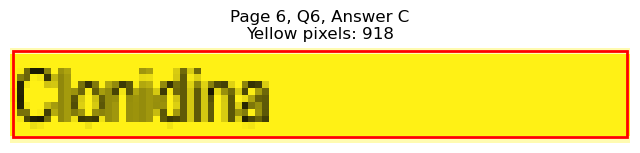

Page 6, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=380.7, y1=405.0
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 364
Page 6, Q6, D: Yellow percentage: 0.0%


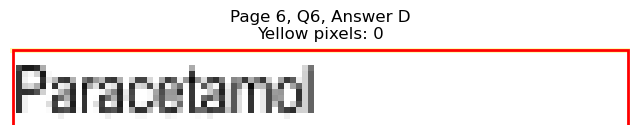


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=120.5, y1=455.5
Page 6, Q7, A: Yellow pixels: 1142
Page 6, Q7, A: Total non-white pixels: 1442
Page 6, Q7, A: Yellow percentage: 79.2%


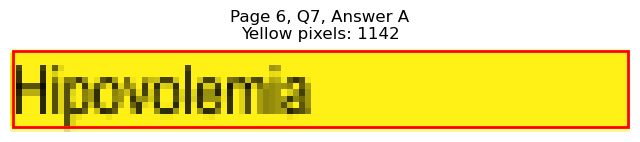

Page 6, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=143.5, y1=468.1
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 368
Page 6, Q7, B: Yellow percentage: 0.0%


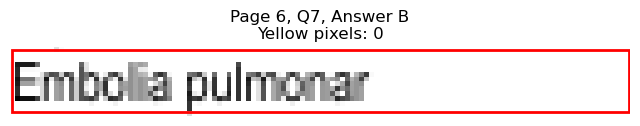

Page 6, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=394.4, y1=455.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 375
Page 6, Q7, C: Yellow percentage: 0.0%


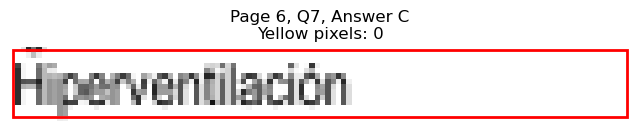

Page 6, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=369.2, y1=468.1
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 216
Page 6, Q7, D: Yellow percentage: 0.0%


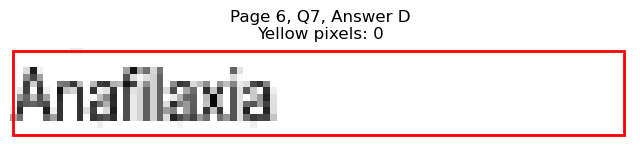


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=65.2, y1=506.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 56
Page 6, Q8, A: Yellow percentage: 0.0%


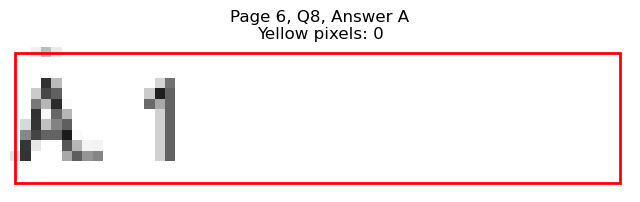

Page 6, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=65.2, y1=518.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 69
Page 6, Q8, B: Yellow percentage: 0.0%


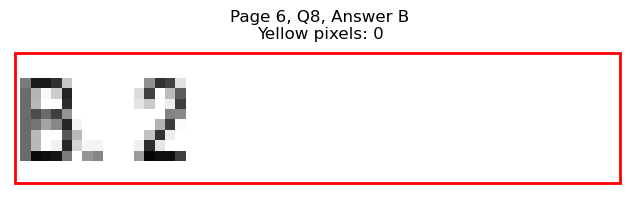

Page 6, Q8 - C: Detected box: x0=315.4, y0=493.4, x1=324.4, y1=506.0
Page 6, Q8, C: Yellow pixels: 60
Page 6, Q8, C: Total non-white pixels: 186
Page 6, Q8, C: Yellow percentage: 32.3%


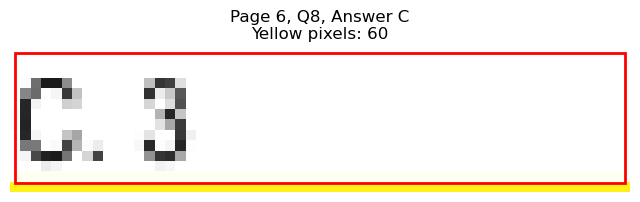

Page 6, Q8 - D: Detected box: x0=315.4, y0=506.0, x1=324.4, y1=518.6
Page 6, Q8, D: Yellow pixels: 726
Page 6, Q8, D: Total non-white pixels: 840
Page 6, Q8, D: Yellow percentage: 86.4%


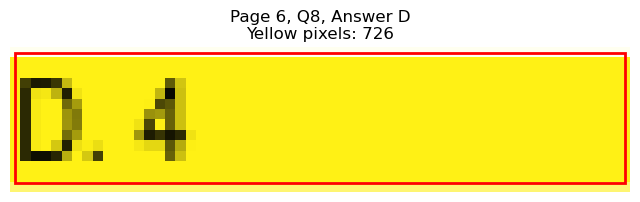


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=139.0, y1=569.2
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 350
Page 6, Q9, A: Yellow percentage: 0.0%


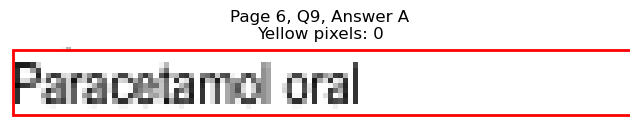

Page 6, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=124.5, y1=581.8
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 294
Page 6, Q9, B: Yellow percentage: 0.0%


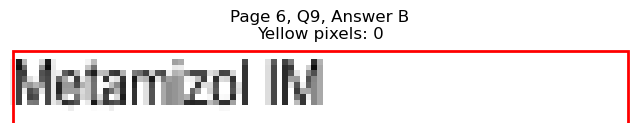

Page 6, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=442.6, y1=569.2
Page 6, Q9, C: Yellow pixels: 1734
Page 6, Q9, C: Total non-white pixels: 2324
Page 6, Q9, C: Yellow percentage: 74.6%


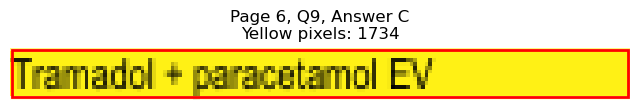

Page 6, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=396.3, y1=581.8
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 471
Page 6, Q9, D: Yellow percentage: 0.0%


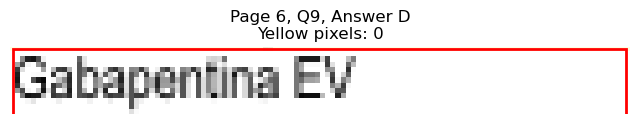


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=237.4, y1=619.6
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 874
Page 6, Q10, A: Yellow percentage: 0.0%


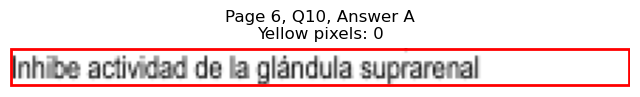

Page 6, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=137.2, y1=632.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 343
Page 6, Q10, B: Yellow percentage: 0.0%


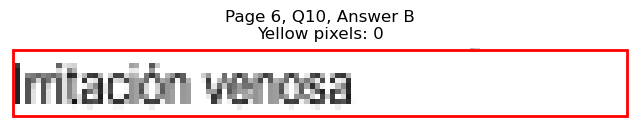

Page 6, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=415.9, y1=619.6
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 474
Page 6, Q10, C: Yellow percentage: 0.0%


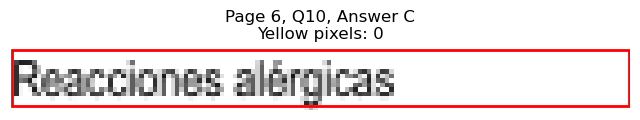

Page 6, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=418.9, y1=632.3
Page 6, Q10, D: Yellow pixels: 1328
Page 6, Q10, D: Total non-white pixels: 1988
Page 6, Q10, D: Yellow percentage: 66.8%


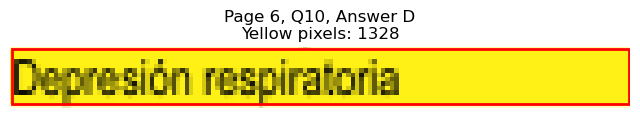


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=126.5, y1=670.1
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 240
Page 6, Q11, A: Yellow percentage: 0.0%


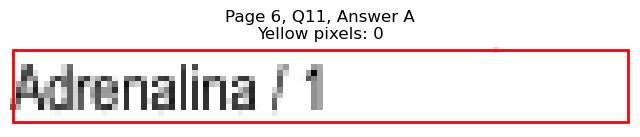

Page 6, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=124.5, y1=682.7
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 266
Page 6, Q11, B: Yellow percentage: 0.0%


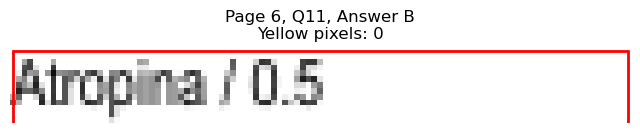

Page 6, Q11 - C: Detected box: x0=327.5, y0=657.5, x1=376.3, y1=670.1
Page 6, Q11, C: Yellow pixels: 1119
Page 6, Q11, C: Total non-white pixels: 1400
Page 6, Q11, C: Yellow percentage: 79.9%


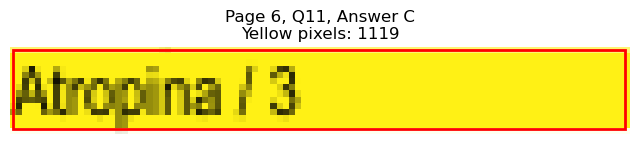

Page 6, Q11 - D: Detected box: x0=327.5, y0=670.1, x1=396.3, y1=682.7
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 455
Page 6, Q11, D: Yellow percentage: 0.0%


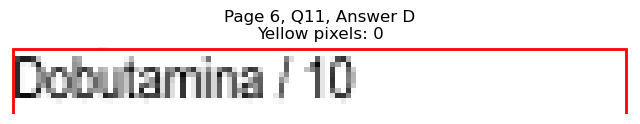


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=708.0, x1=100.9, y1=720.6
Page 6, Q12, A: Yellow pixels: 83
Page 6, Q12, A: Total non-white pixels: 251
Page 6, Q12, A: Yellow percentage: 33.1%


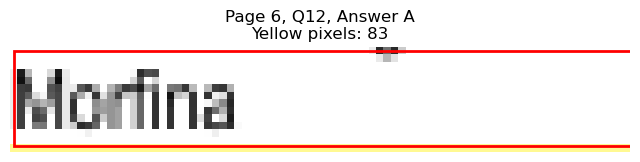

Page 6, Q12 - B: Detected box: x0=68.3, y0=720.6, x1=120.5, y1=733.2
Page 6, Q12, B: Yellow pixels: 1131
Page 6, Q12, B: Total non-white pixels: 1442
Page 6, Q12, B: Yellow percentage: 78.4%


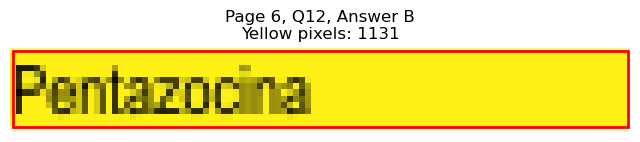

Page 6, Q12 - C: Detected box: x0=327.5, y0=708.0, x1=367.1, y1=720.6
Page 6, Q12, C: Yellow pixels: 0
Page 6, Q12, C: Total non-white pixels: 200
Page 6, Q12, C: Yellow percentage: 0.0%


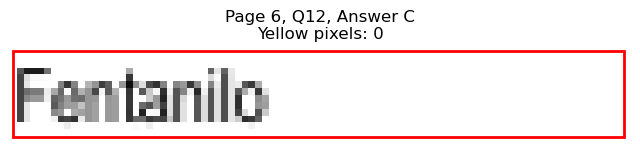

Page 6, Q12 - D: Detected box: x0=327.5, y0=720.6, x1=384.7, y1=733.2
Page 6, Q12, D: Yellow pixels: 0
Page 6, Q12, D: Total non-white pixels: 293
Page 6, Q12, D: Yellow percentage: 0.0%


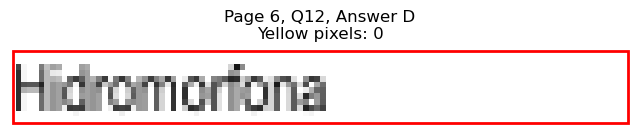


Page 6, Q12 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=103.9, y1=102.1
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 135
Page 7, Q1, A: Yellow percentage: 0.0%


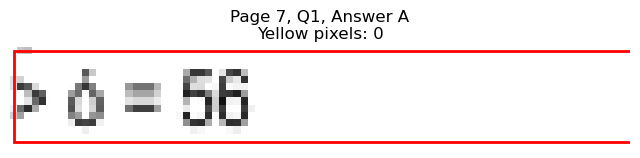

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=103.9, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 111
Page 7, Q1, B: Yellow percentage: 0.0%


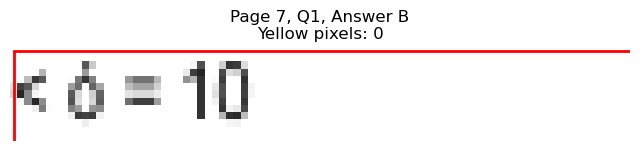

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=363.2, y1=102.1
Page 7, Q1, C: Yellow pixels: 87
Page 7, Q1, C: Total non-white pixels: 209
Page 7, Q1, C: Yellow percentage: 41.6%


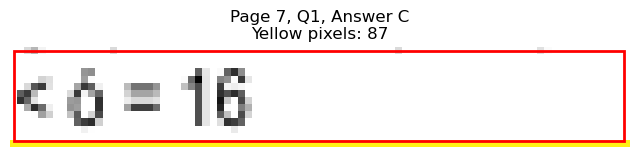

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=363.2, y1=114.7
Page 7, Q1, D: Yellow pixels: 1035
Page 7, Q1, D: Total non-white pixels: 1131
Page 7, Q1, D: Yellow percentage: 91.5%


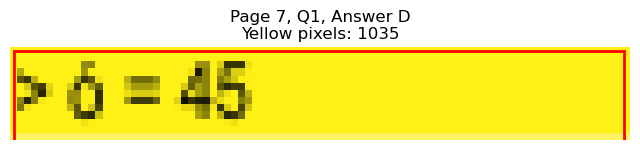


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=65.2, y1=165.2
Page 7, Q2, A: Yellow pixels: 60
Page 7, Q2, A: Total non-white pixels: 119
Page 7, Q2, A: Yellow percentage: 50.4%


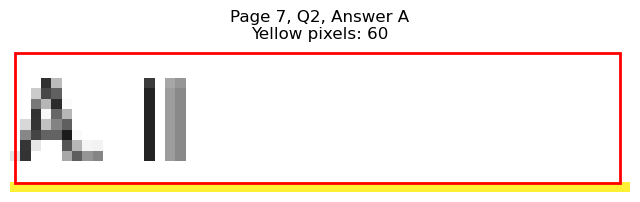

Page 7, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=78.4, y1=177.8
Page 7, Q2, B: Yellow pixels: 761
Page 7, Q2, B: Total non-white pixels: 793
Page 7, Q2, B: Yellow percentage: 96.0%


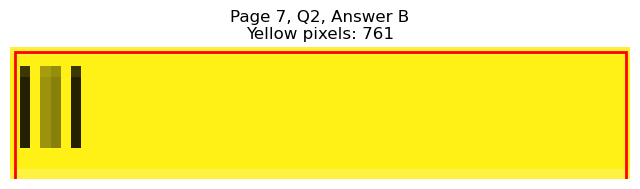

Page 7, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=338.6, y1=165.2
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 42
Page 7, Q2, C: Yellow percentage: 0.0%


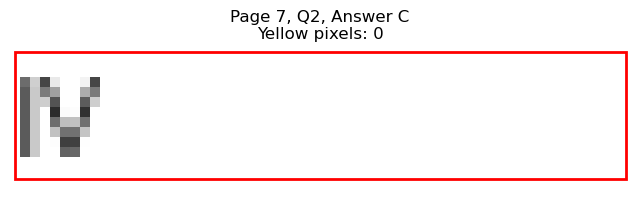

Page 7, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 69
Page 7, Q2, D: Yellow percentage: 0.0%


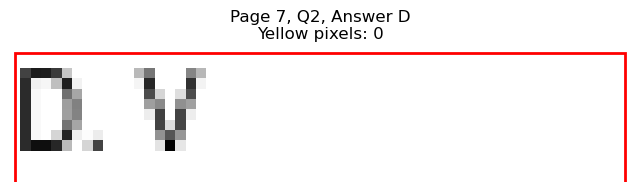


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=101.7, y1=240.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 209
Page 7, Q3, A: Yellow percentage: 0.0%


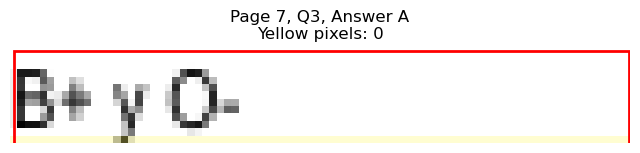

Page 7, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=99.4, y1=253.5
Page 7, Q3, B: Yellow pixels: 980
Page 7, Q3, B: Total non-white pixels: 1148
Page 7, Q3, B: Yellow percentage: 85.4%


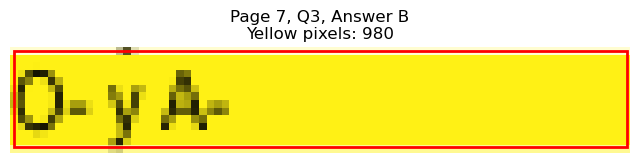

Page 7, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=368.2, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 161
Page 7, Q3, C: Yellow percentage: 0.0%


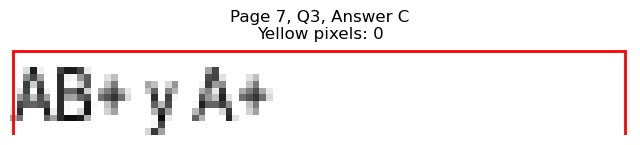

Page 7, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=363.2, y1=253.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 137
Page 7, Q3, D: Yellow percentage: 0.0%


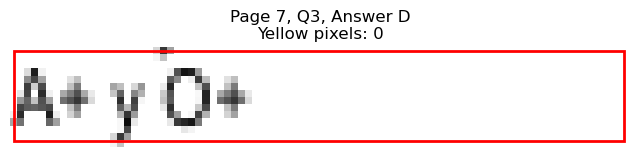


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=317.1, y1=291.5
Page 7, Q4, A: Yellow pixels: 300
Page 7, Q4, A: Total non-white pixels: 1528
Page 7, Q4, A: Yellow percentage: 19.6%


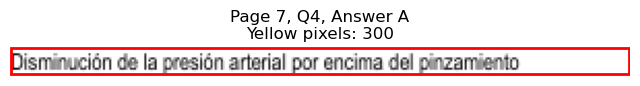

Page 7, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=304.0, y1=304.1
Page 7, Q4, B: Yellow pixels: 2799
Page 7, Q4, B: Total non-white pixels: 4018
Page 7, Q4, B: Yellow percentage: 69.7%


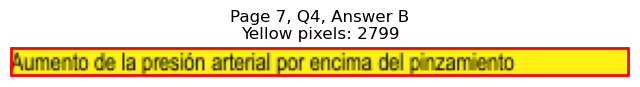

Page 7, Q4 - C: Detected box: x0=68.8, y0=304.0, x1=243.3, y1=316.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 1037
Page 7, Q4, C: Yellow percentage: 0.0%


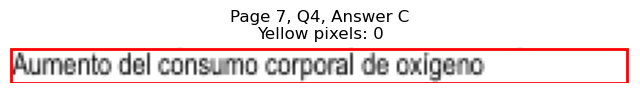

Page 7, Q4 - D: Detected box: x0=68.8, y0=316.6, x1=154.6, y1=329.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 438
Page 7, Q4, D: Yellow percentage: 0.0%


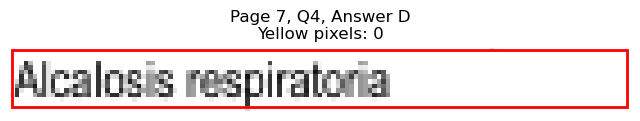


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=298.1, y1=367.2
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 1158
Page 7, Q5, A: Yellow percentage: 0.0%


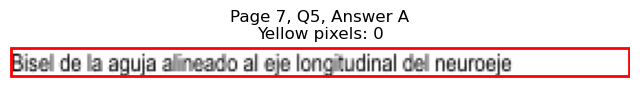

Page 7, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=130.0, y1=379.8
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 320
Page 7, Q5, B: Yellow percentage: 0.0%


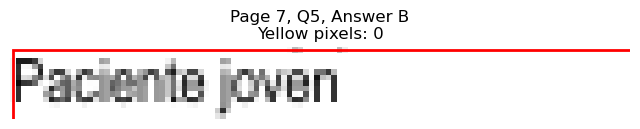

Page 7, Q5 - C: Detected box: x0=68.8, y0=379.7, x1=278.0, y1=392.4
Page 7, Q5, C: Yellow pixels: 260
Page 7, Q5, C: Total non-white pixels: 1314
Page 7, Q5, C: Yellow percentage: 19.8%


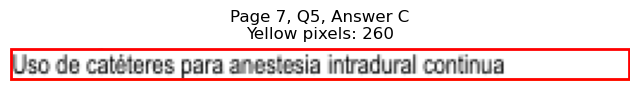

Page 7, Q5 - D: Detected box: x0=68.8, y0=392.3, x1=311.1, y1=405.0
Page 7, Q5, D: Yellow pixels: 2852
Page 7, Q5, D: Total non-white pixels: 3822
Page 7, Q5, D: Yellow percentage: 74.6%


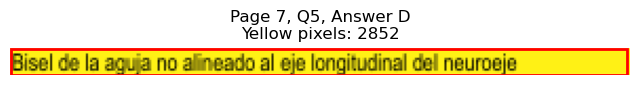


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=102.4, y1=455.5
Page 7, Q6, A: Yellow pixels: 986
Page 7, Q6, A: Total non-white pixels: 1190
Page 7, Q6, A: Yellow percentage: 82.9%


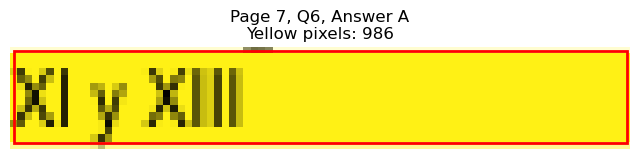

Page 7, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=182.7, y1=468.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 558
Page 7, Q6, B: Yellow percentage: 0.0%


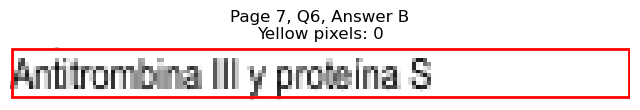

Page 7, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=350.6, y1=455.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 87
Page 7, Q6, C: Yellow percentage: 0.0%


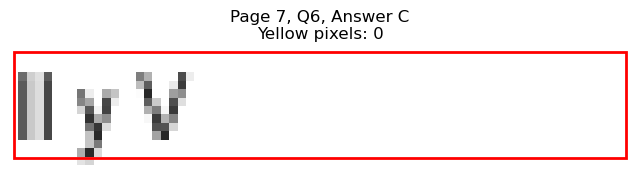

Page 7, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=440.9, y1=468.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 544
Page 7, Q6, D: Yellow percentage: 0.0%


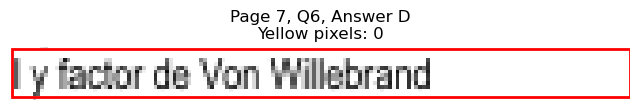


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=100.9, y1=518.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 164
Page 7, Q7, A: Yellow percentage: 0.0%


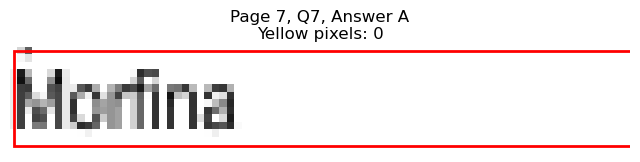

Page 7, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=106.9, y1=531.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 194
Page 7, Q7, B: Yellow percentage: 0.0%


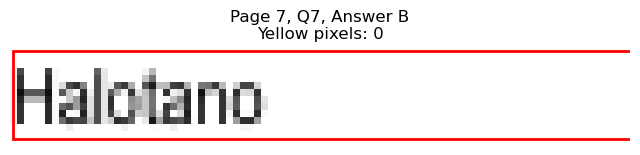

Page 7, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=385.3, y1=518.6
Page 7, Q7, C: Yellow pixels: 1185
Page 7, Q7, C: Total non-white pixels: 1526
Page 7, Q7, C: Yellow percentage: 77.7%


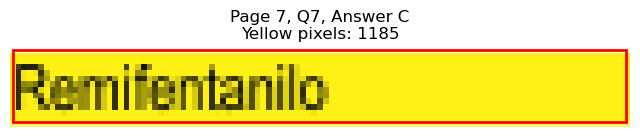

Page 7, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=376.1, y1=531.2
Page 7, Q7, D: Yellow pixels: 100
Page 7, Q7, D: Total non-white pixels: 368
Page 7, Q7, D: Yellow percentage: 27.2%


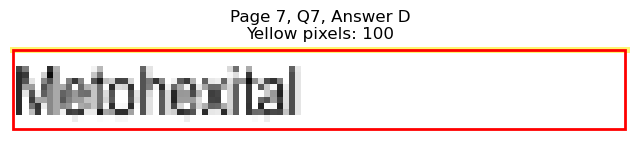


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=79.3, y1=569.2
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 36
Page 7, Q8, A: Yellow percentage: 0.0%


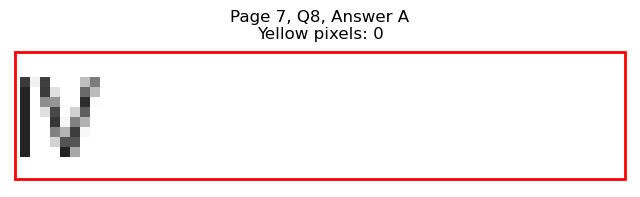

Page 7, Q8 - B: Detected box: x0=68.3, y0=165.1, x1=78.4, y1=177.8
Page 7, Q8, B: Yellow pixels: 761
Page 7, Q8, B: Total non-white pixels: 793
Page 7, Q8, B: Yellow percentage: 96.0%


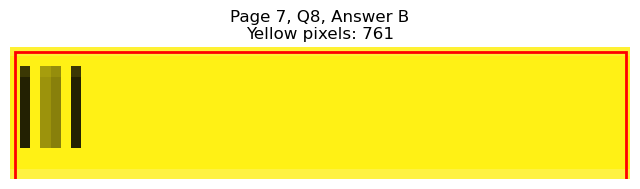

Page 7, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=324.4, y1=569.2
Page 7, Q8, C: Yellow pixels: 733
Page 7, Q8, C: Total non-white pixels: 840
Page 7, Q8, C: Yellow percentage: 87.3%


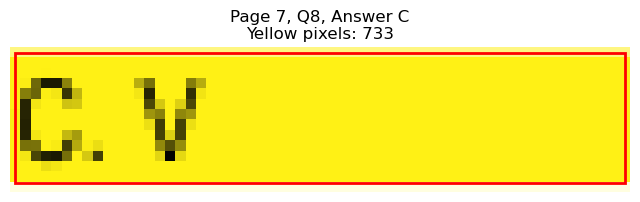

Page 7, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=338.6, y1=581.8
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 107
Page 7, Q8, D: Yellow percentage: 0.0%


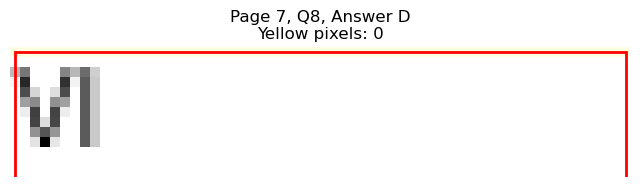


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=180.1, y1=632.3
Page 7, Q9, A: Yellow pixels: 1507
Page 7, Q9, A: Total non-white pixels: 2282
Page 7, Q9, A: Yellow percentage: 66.0%


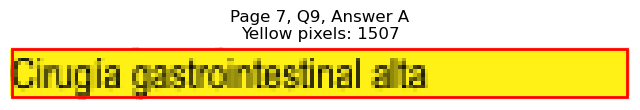

Page 7, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=118.0, y1=644.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 365
Page 7, Q9, B: Yellow percentage: 0.0%


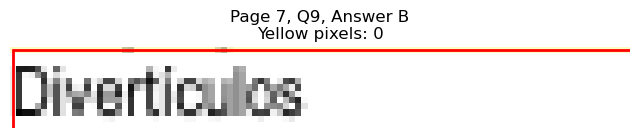

Page 7, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=356.1, y1=632.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 122
Page 7, Q9, C: Yellow percentage: 0.0%


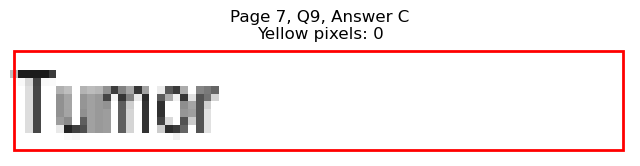

Page 7, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=374.2, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 225
Page 7, Q9, D: Yellow percentage: 0.0%


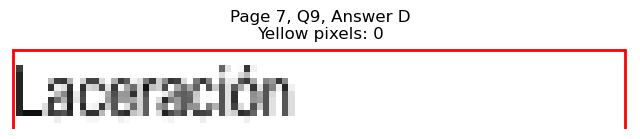


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=112.0, y1=682.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 287
Page 7, Q10, A: Yellow percentage: 0.0%


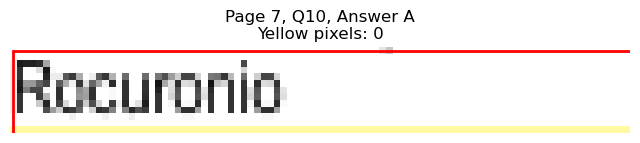

Page 7, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=125.4, y1=695.3
Page 7, Q10, B: Yellow pixels: 1064
Page 7, Q10, B: Total non-white pixels: 1512
Page 7, Q10, B: Yellow percentage: 70.4%


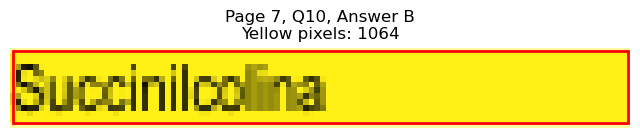

Page 7, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=375.7, y1=682.7
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 228
Page 7, Q10, C: Yellow percentage: 0.0%


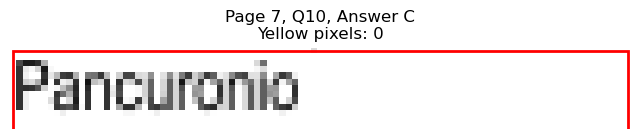

Page 7, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=366.2, y1=695.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 184
Page 7, Q10, D: Yellow percentage: 0.0%


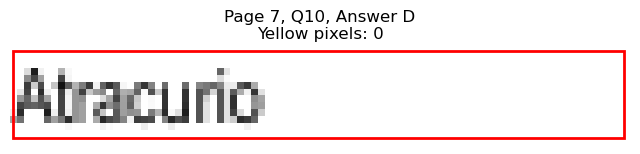


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=88.3, y1=733.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 90
Page 7, Q11, A: Yellow percentage: 0.0%


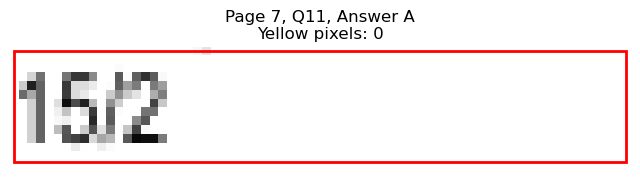

Page 7, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=83.4, y1=745.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 66
Page 7, Q11, B: Yellow percentage: 0.0%


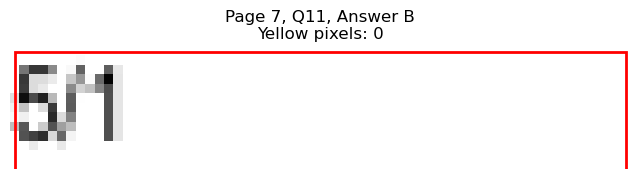

Page 7, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=347.6, y1=733.2
Page 7, Q11, C: Yellow pixels: 71
Page 7, Q11, C: Total non-white pixels: 146
Page 7, Q11, C: Yellow percentage: 48.6%


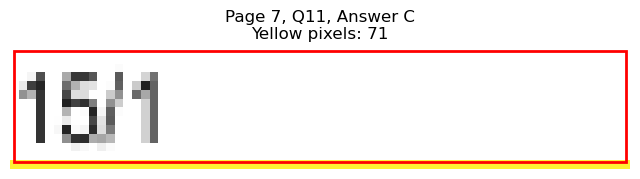

Page 7, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=347.6, y1=745.8
Page 7, Q11, D: Yellow pixels: 853
Page 7, Q11, D: Total non-white pixels: 923
Page 7, Q11, D: Yellow percentage: 92.4%


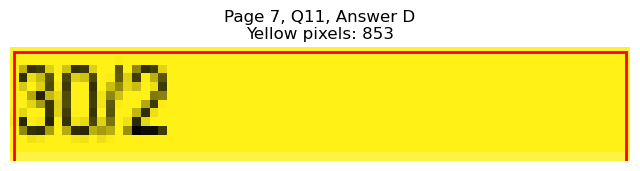


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=165.3, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 458
Page 8, Q1, A: Yellow percentage: 0.0%


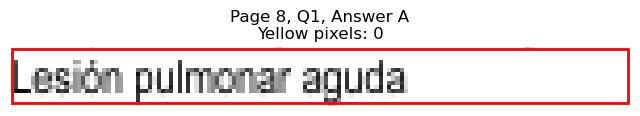

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=159.6, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 435
Page 8, Q1, B: Yellow percentage: 0.0%


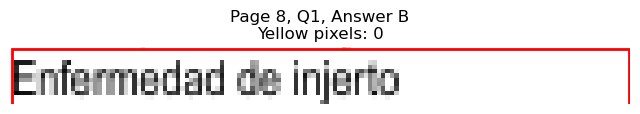

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=406.3, y1=127.3
Page 8, Q1, C: Yellow pixels: 130
Page 8, Q1, C: Total non-white pixels: 519
Page 8, Q1, C: Yellow percentage: 25.0%


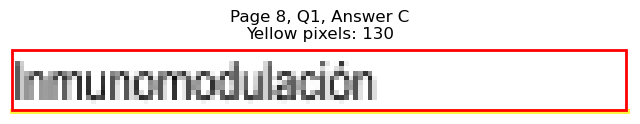

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=422.8, y1=139.9
Page 8, Q1, D: Yellow pixels: 1523
Page 8, Q1, D: Total non-white pixels: 1898
Page 8, Q1, D: Yellow percentage: 80.2%


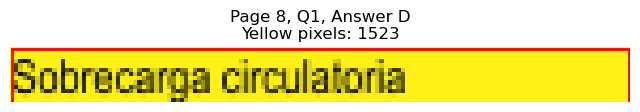


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=143.5, y1=203.0
Page 8, Q2, A: Yellow pixels: 1350
Page 8, Q2, A: Total non-white pixels: 1638
Page 8, Q2, A: Yellow percentage: 82.4%


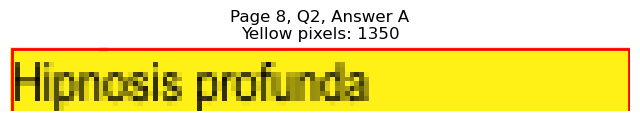

Page 8, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=109.5, y1=215.6
Page 8, Q2, B: Yellow pixels: 90
Page 8, Q2, B: Total non-white pixels: 301
Page 8, Q2, B: Yellow percentage: 29.9%


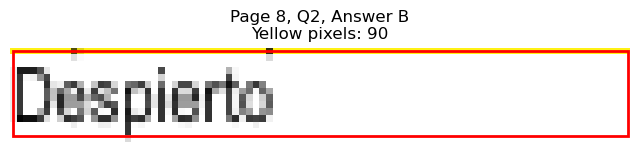

Page 8, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=410.8, y1=203.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 420
Page 8, Q2, C: Yellow percentage: 0.0%


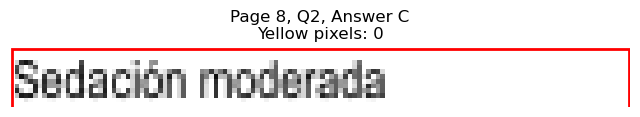

Page 8, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=402.3, y1=215.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 385
Page 8, Q2, D: Yellow percentage: 0.0%


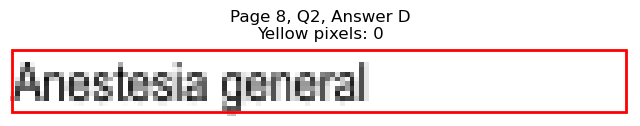


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=369.5, y1=253.5
Page 8, Q3, A: Yellow pixels: 3444
Page 8, Q3, A: Total non-white pixels: 4928
Page 8, Q3, A: Yellow percentage: 69.9%


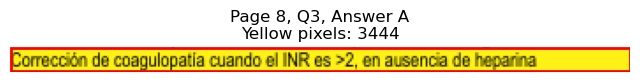

Page 8, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=399.3, y1=266.1
Page 8, Q3, B: Yellow pixels: 381
Page 8, Q3, B: Total non-white pixels: 2016
Page 8, Q3, B: Yellow percentage: 18.9%


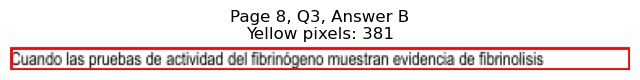

Page 8, Q3 - C: Detected box: x0=68.8, y0=266.1, x1=412.9, y1=278.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 1694
Page 8, Q3, C: Yellow percentage: 0.0%


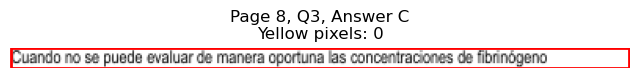

Page 8, Q3 - D: Detected box: x0=68.8, y0=278.8, x1=314.7, y1=291.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 1272
Page 8, Q3, D: Yellow percentage: 0.0%


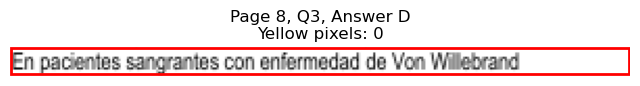


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=237.9, y1=329.3
Page 8, Q4, A: Yellow pixels: 213
Page 8, Q4, A: Total non-white pixels: 1090
Page 8, Q4, A: Yellow percentage: 19.5%


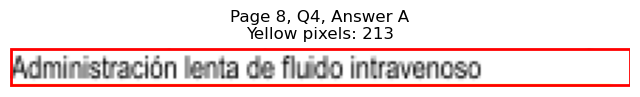

Page 8, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=248.4, y1=341.9
Page 8, Q4, B: Yellow pixels: 2080
Page 8, Q4, B: Total non-white pixels: 2782
Page 8, Q4, B: Yellow percentage: 74.8%


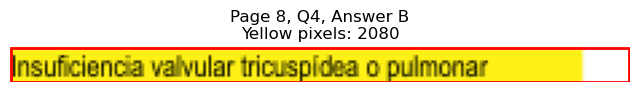

Page 8, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=500.6, y1=329.3
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 874
Page 8, Q4, C: Yellow percentage: 0.0%


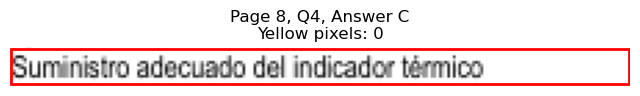

Page 8, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=407.3, y1=341.9
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 396
Page 8, Q4, D: Yellow percentage: 0.0%


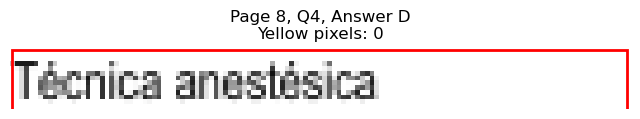


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=109.9, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 201
Page 8, Q5, A: Yellow percentage: 0.0%


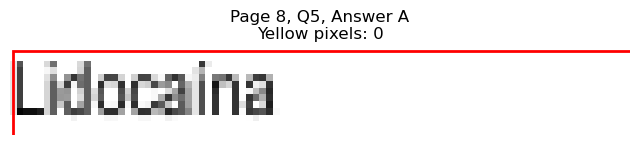

Page 8, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=120.5, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 279
Page 8, Q5, B: Yellow percentage: 0.0%


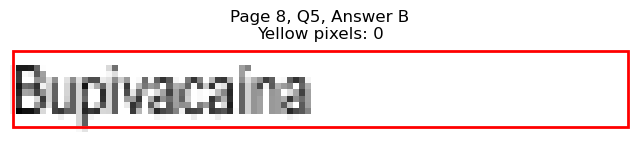

Page 8, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=373.1, y1=379.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 313
Page 8, Q5, C: Yellow percentage: 0.0%


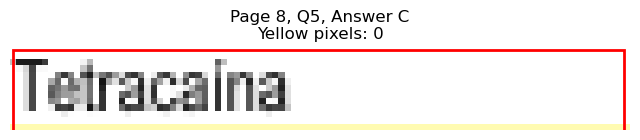

Page 8, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=366.2, y1=392.4
Page 8, Q5, D: Yellow pixels: 948
Page 8, Q5, D: Total non-white pixels: 1260
Page 8, Q5, D: Yellow percentage: 75.2%


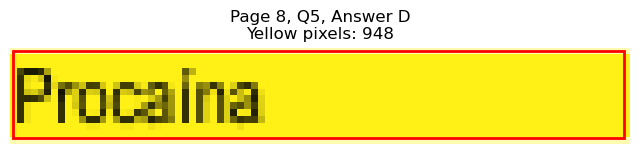


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=118.9, y1=468.1
Page 8, Q6, A: Yellow pixels: 101
Page 8, Q6, A: Total non-white pixels: 335
Page 8, Q6, A: Yellow percentage: 30.1%


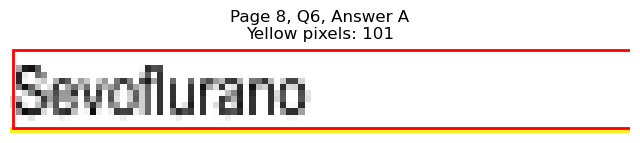

Page 8, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=125.4, y1=480.7
Page 8, Q6, B: Yellow pixels: 1172
Page 8, Q6, B: Total non-white pixels: 1404
Page 8, Q6, B: Yellow percentage: 83.5%


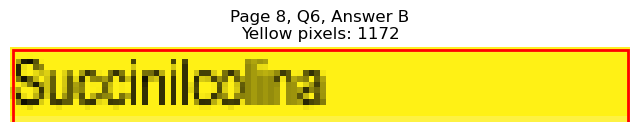

Page 8, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=367.1, y1=468.1
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 200
Page 8, Q6, C: Yellow percentage: 0.0%


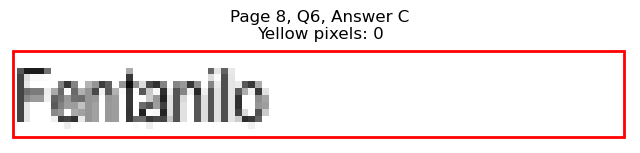

Page 8, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=390.8, y1=480.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 317
Page 8, Q6, D: Yellow percentage: 0.0%


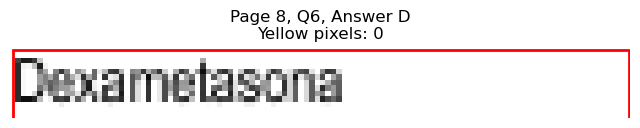


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=153.5, y1=518.6
Page 8, Q7, A: Yellow pixels: 1426
Page 8, Q7, A: Total non-white pixels: 1904
Page 8, Q7, A: Yellow percentage: 74.9%


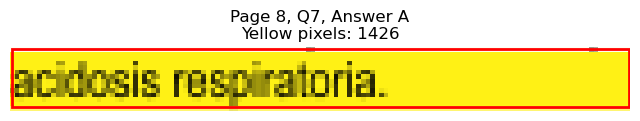

Page 8, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=155.5, y1=531.2
Page 8, Q7, B: Yellow pixels: 138
Page 8, Q7, B: Total non-white pixels: 582
Page 8, Q7, B: Yellow percentage: 23.7%


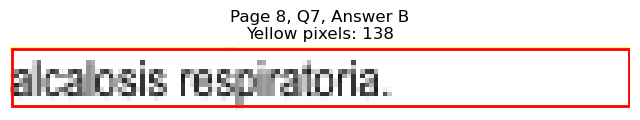

Page 8, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=413.3, y1=518.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 437
Page 8, Q7, C: Yellow percentage: 0.0%


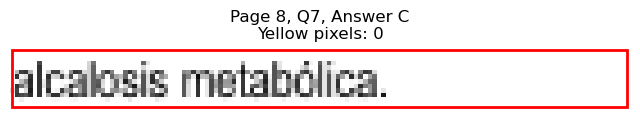

Page 8, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=411.3, y1=531.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 431
Page 8, Q7, D: Yellow percentage: 0.0%


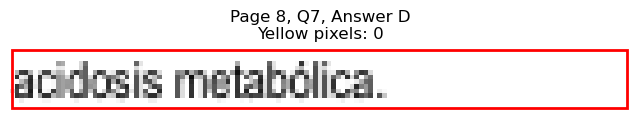


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=144.5, y1=581.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 386
Page 8, Q8, A: Yellow percentage: 0.0%


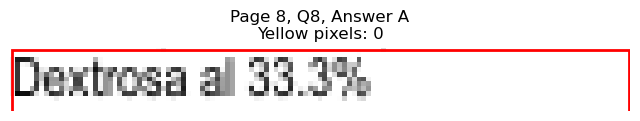

Page 8, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=121.5, y1=594.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 276
Page 8, Q8, B: Yellow percentage: 0.0%


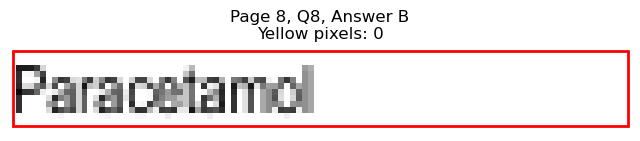

Page 8, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=371.2, y1=581.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 323
Page 8, Q8, C: Yellow percentage: 0.0%


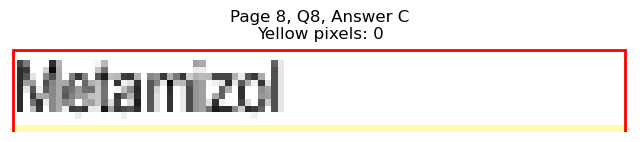

Page 8, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=378.3, y1=594.4
Page 8, Q8, D: Yellow pixels: 1021
Page 8, Q8, D: Total non-white pixels: 1428
Page 8, Q8, D: Yellow percentage: 71.5%


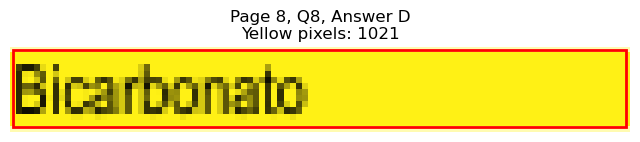


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=195.7, y1=644.9
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 644
Page 8, Q9, A: Yellow percentage: 0.0%


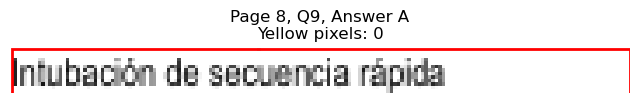

Page 8, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=206.8, y1=657.5
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 723
Page 8, Q9, B: Yellow percentage: 0.0%


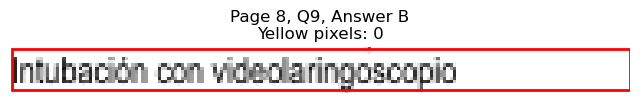

Page 8, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=399.9, y1=644.9
Page 8, Q9, C: Yellow pixels: 1292
Page 8, Q9, C: Total non-white pixels: 1599
Page 8, Q9, C: Yellow percentage: 80.8%


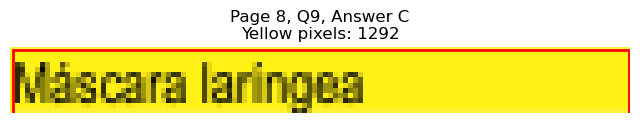

Page 8, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=517.2, y1=657.5
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 976
Page 8, Q9, D: Yellow percentage: 0.0%


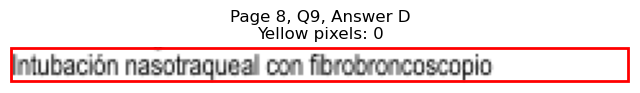


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=112.5, y1=708.0
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 223
Page 8, Q10, A: Yellow percentage: 0.0%


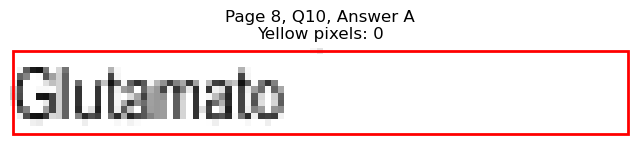

Page 8, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=115.0, y1=720.6
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 235
Page 8, Q10, B: Yellow percentage: 0.0%


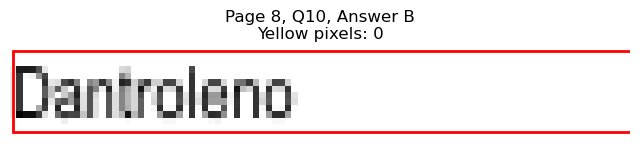

Page 8, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=370.1, y1=708.0
Page 8, Q10, C: Yellow pixels: 1056
Page 8, Q10, C: Total non-white pixels: 1222
Page 8, Q10, C: Yellow percentage: 86.4%


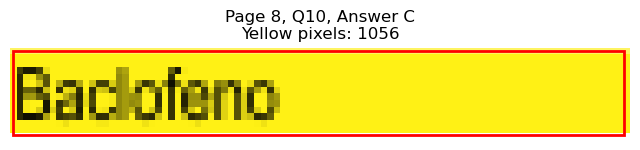

Page 8, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=378.2, y1=720.6
Page 8, Q10, D: Yellow pixels: 102
Page 8, Q10, D: Total non-white pixels: 365
Page 8, Q10, D: Yellow percentage: 27.9%


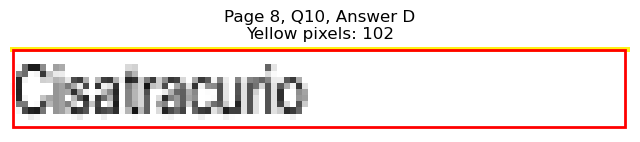


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=109.0, y1=758.4
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 204
Page 8, Q11, A: Yellow percentage: 0.0%


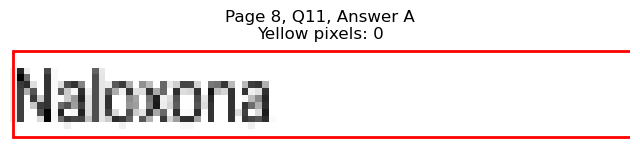

Page 8, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=126.5, y1=771.2
Page 8, Q11, B: Yellow pixels: 1188
Page 8, Q11, B: Total non-white pixels: 1526
Page 8, Q11, B: Yellow percentage: 77.9%


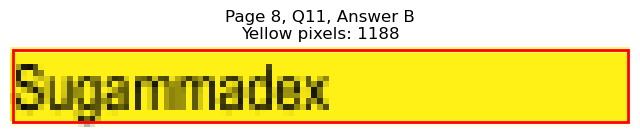

Page 8, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=363.7, y1=758.4
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 192
Page 8, Q11, C: Yellow percentage: 0.0%


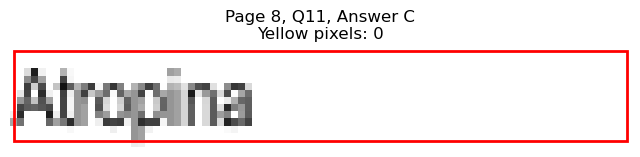

Page 8, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=380.2, y1=771.2
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 296
Page 8, Q11, D: Yellow percentage: 0.0%


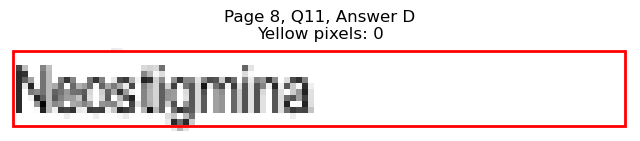


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=110.9, y1=102.1
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 204
Page 9, Q1, A: Yellow percentage: 0.0%


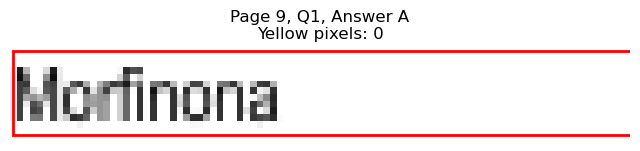

Page 9, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=122.4, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 283
Page 9, Q1, B: Yellow percentage: 0.0%


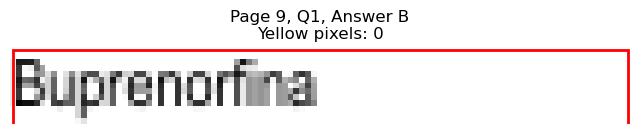

Page 9, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=362.8, y1=102.1
Page 9, Q1, C: Yellow pixels: 980
Page 9, Q1, C: Total non-white pixels: 1204
Page 9, Q1, C: Yellow percentage: 81.4%


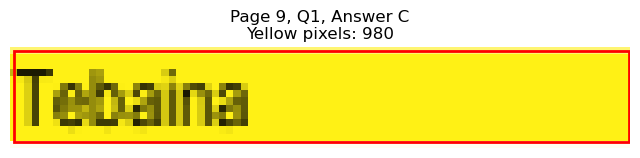

Page 9, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=370.1, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 317
Page 9, Q1, D: Yellow percentage: 0.0%


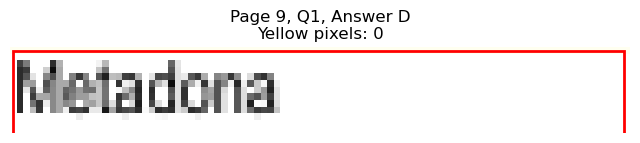


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=142.6, y1=152.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 373
Page 9, Q2, A: Yellow percentage: 0.0%


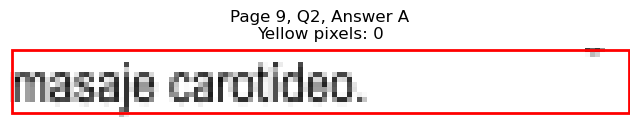

Page 9, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=130.1, y1=165.2
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 347
Page 9, Q2, B: Yellow percentage: 0.0%


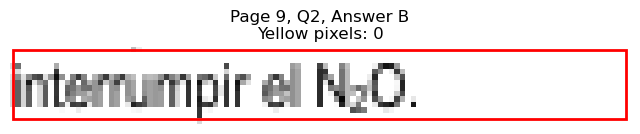

Page 9, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=411.3, y1=152.6
Page 9, Q2, C: Yellow pixels: 1417
Page 9, Q2, C: Total non-white pixels: 1890
Page 9, Q2, C: Yellow percentage: 75.0%


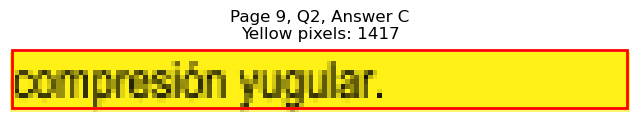

Page 9, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=413.3, y1=165.2
Page 9, Q2, D: Yellow pixels: 135
Page 9, Q2, D: Total non-white pixels: 565
Page 9, Q2, D: Yellow percentage: 23.9%


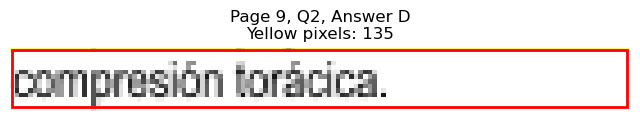


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=107.9, y1=203.0
Page 9, Q3, A: Yellow pixels: 1030
Page 9, Q3, A: Total non-white pixels: 1170
Page 9, Q3, A: Yellow percentage: 88.0%


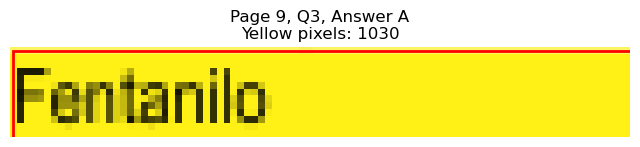

Page 9, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=100.9, y1=215.6
Page 9, Q3, B: Yellow pixels: 83
Page 9, Q3, B: Total non-white pixels: 243
Page 9, Q3, B: Yellow percentage: 34.2%


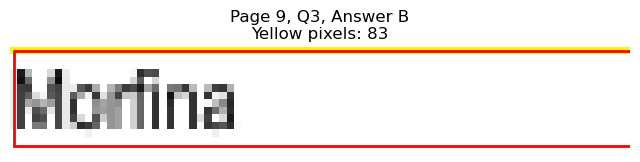

Page 9, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=388.7, y1=203.0
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 332
Page 9, Q3, C: Yellow percentage: 0.0%


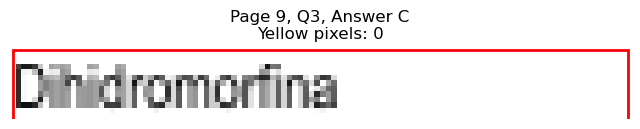

Page 9, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=364.1, y1=215.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 187
Page 9, Q3, D: Yellow percentage: 0.0%


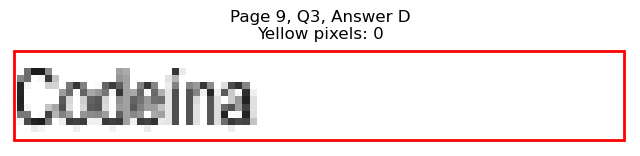


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=124.0, y1=266.1
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 277
Page 9, Q4, A: Yellow percentage: 0.0%


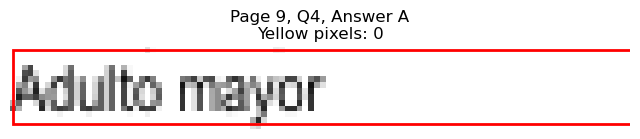

Page 9, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=150.5, y1=278.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 400
Page 9, Q4, B: Yellow percentage: 0.0%


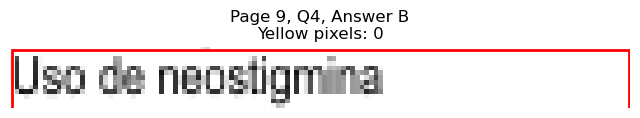

Page 9, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=475.1, y1=266.1
Page 9, Q4, C: Yellow pixels: 2015
Page 9, Q4, C: Total non-white pixels: 2786
Page 9, Q4, C: Yellow percentage: 72.3%


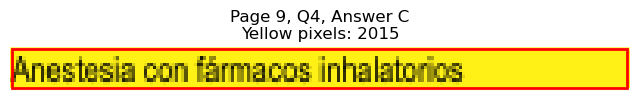

Page 9, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=411.3, y1=278.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 571
Page 9, Q4, D: Yellow percentage: 0.0%


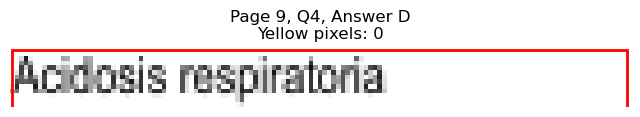


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=100.9, y1=329.3
Page 9, Q5, A: Yellow pixels: 83
Page 9, Q5, A: Total non-white pixels: 245
Page 9, Q5, A: Yellow percentage: 33.9%


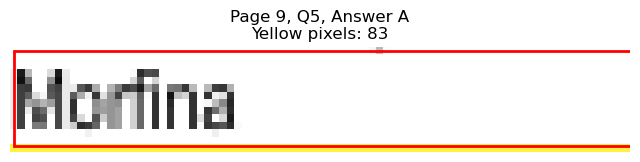

Page 9, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=109.0, y1=341.9
Page 9, Q5, B: Yellow pixels: 1030
Page 9, Q5, B: Total non-white pixels: 1183
Page 9, Q5, B: Yellow percentage: 87.1%


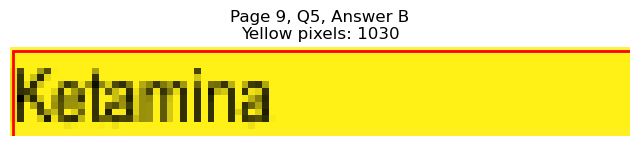

Page 9, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=369.7, y1=329.3
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 219
Page 9, Q5, C: Yellow percentage: 0.0%


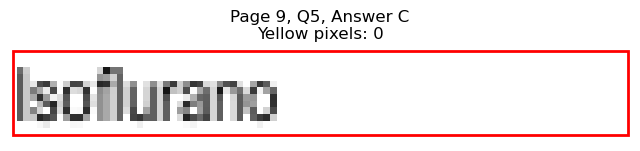

Page 9, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=367.1, y1=341.9
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 200
Page 9, Q5, D: Yellow percentage: 0.0%


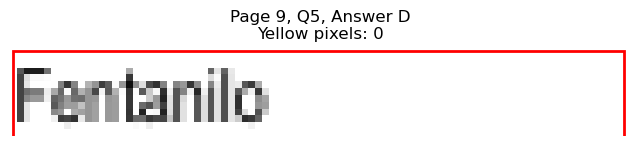


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=94.0, y1=379.8
Page 9, Q6, A: Yellow pixels: 899
Page 9, Q6, A: Total non-white pixels: 988
Page 9, Q6, A: Yellow percentage: 91.0%


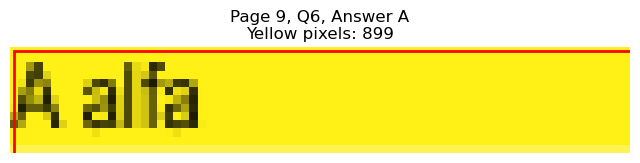

Page 9, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=99.0, y1=392.4
Page 9, Q6, B: Yellow pixels: 82
Page 9, Q6, B: Total non-white pixels: 232
Page 9, Q6, B: Yellow percentage: 35.3%


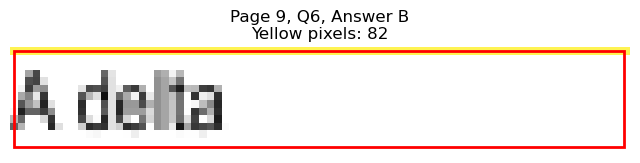

Page 9, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=356.2, y1=379.8
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 135
Page 9, Q6, C: Yellow percentage: 0.0%


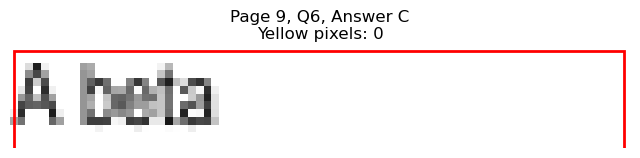

Page 9, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=336.5, y1=392.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 33
Page 9, Q6, D: Yellow percentage: 0.0%


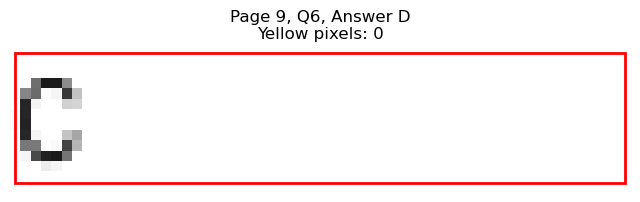


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=130.0, y1=442.9
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 372
Page 9, Q7, A: Yellow percentage: 0.0%


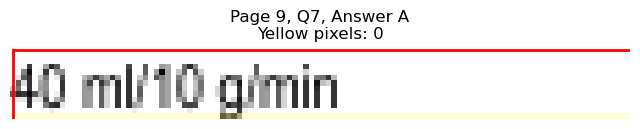

Page 9, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=135.0, y1=455.5
Page 9, Q7, B: Yellow pixels: 1268
Page 9, Q7, B: Total non-white pixels: 1652
Page 9, Q7, B: Yellow percentage: 76.8%


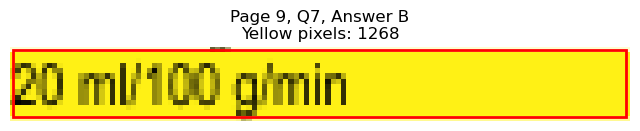

Page 9, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=394.3, y1=442.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 333
Page 9, Q7, C: Yellow percentage: 0.0%


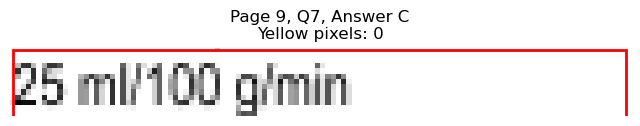

Page 9, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=394.3, y1=455.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 342
Page 9, Q7, D: Yellow percentage: 0.0%


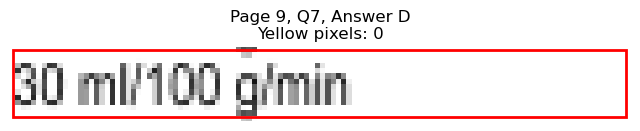


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=493.4, x1=103.9, y1=506.0
Page 9, Q8, A: Yellow pixels: 86
Page 9, Q8, A: Total non-white pixels: 344
Page 9, Q8, A: Yellow percentage: 25.0%


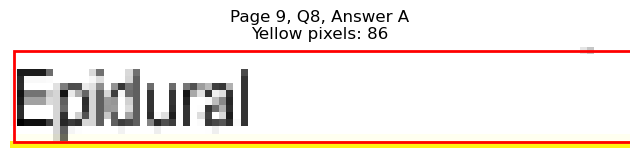

Page 9, Q8 - B: Detected box: x0=68.3, y0=506.0, x1=102.9, y1=518.6
Page 9, Q8, B: Yellow pixels: 984
Page 9, Q8, B: Total non-white pixels: 1190
Page 9, Q8, B: Yellow percentage: 82.7%


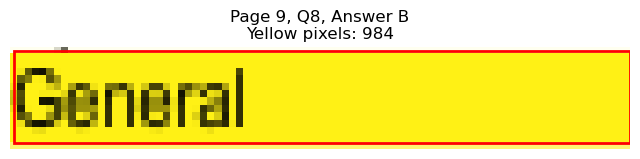

Page 9, Q8 - C: Detected box: x0=327.5, y0=493.4, x1=369.2, y1=506.0
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 228
Page 9, Q8, C: Yellow percentage: 0.0%


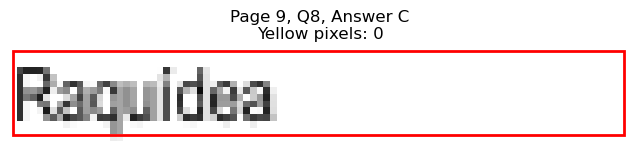

Page 9, Q8 - D: Detected box: x0=327.5, y0=506.0, x1=410.8, y1=518.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 432
Page 9, Q8, D: Yellow percentage: 0.0%


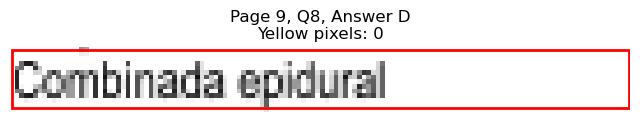


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=543.8, x1=106.9, y1=556.4
Page 9, Q9, A: Yellow pixels: 1020
Page 9, Q9, A: Total non-white pixels: 1246
Page 9, Q9, A: Yellow percentage: 81.9%


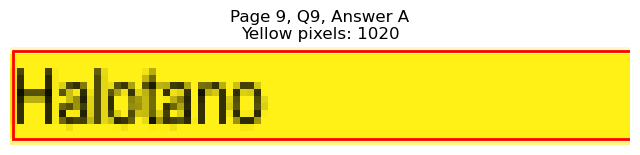

Page 9, Q9 - B: Detected box: x0=68.3, y0=556.5, x1=118.9, y1=569.2
Page 9, Q9, B: Yellow pixels: 101
Page 9, Q9, B: Total non-white pixels: 335
Page 9, Q9, B: Yellow percentage: 30.1%


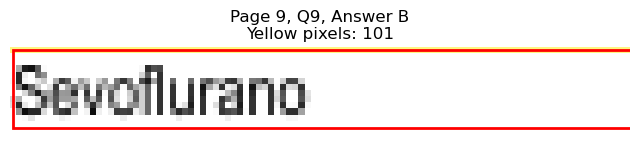

Page 9, Q9 - C: Detected box: x0=327.5, y0=316.6, x1=369.7, y1=329.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 219
Page 9, Q9, C: Yellow percentage: 0.0%


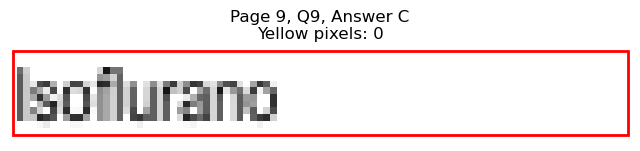

Page 9, Q9 - D: Detected box: x0=327.5, y0=556.5, x1=373.7, y1=569.2
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 241
Page 9, Q9, D: Yellow percentage: 0.0%


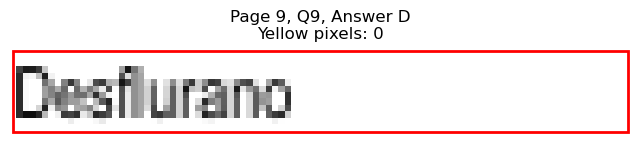


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   En cirugía cardíaca. ¿Cuál es el cambio fisiol...
1   ¿Cuál es factor de riesgo, relacionado con cir...
2   ¿Cuál es factor de riesgo moderado para trombo...
3   ¿Cuál es el anestésico local tipo amida, con i...
4   Varón de 59 años, obeso, sin otro antecedente ...
..                                                ...
95  Mujer de 45 años, con asma crónica no controla...
96  ¿Cuál es la fibra de dolor localizada en los e...
97  El flujo sanguíneo cerebral normal de la susta...
98  Gestante 38 semanas, ASA II, con antecedente d...
99  ¿Cuál es el anestésico volátil que tiene mayor...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Aumenta la presión por debajo de la pinza   
1                    Alteraciones sensoriales   
2                           Disfibrinogenemia   
3                                 Mepivacaína   
4                       Reacción anafiláctica   
..                                        ...   
95                                    Morfina   
96                                     A alfa   
97                             40 ml/10 g/min   
98                                   Epidural   
99                                   Halotano   

                                  option_B  \
0   Disminución de la fracción de eyección   
1               Cirugía abdominal superior   
2                       Déficit proteína C   
3                                 Procaína   
4                     Infección bacteriana   
..                                     ...   
95                                Ketamina   
96                                 A delta   
97                         20 ml/100 g/min   
98                                 General   
99                             Sevoflurano   

                                        option_C  \
0   Disminución de la adrenalina y noradrenalina   
1                                     Tabaquismo   
2                        Déficit de antitrombina   
3                                   Clorprocaína   
4                        Hemólisis transfusional   
..                                           ...   
95                                    Isoflurano   
96                                        A beta   
97                               25 ml/100 g/min   
98                                      Raquídea   
99                                    Isoflurano   

                                     option_D  
0   Disminución del flujo sanguíneo coronario  
1                        Cirugía artroscópica  
2       Trombocitopenia inducida por heparina  
3                                  Tetracaína  
4                       Lesión pulmonar aguda  
..                                        ...  
95                                  Fentanilo  
96                                          C  
97                            30 ml/100 g/min  
98                         Combinada epidural  
99                                 Desflurano  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   En cirugía cardíaca. ¿Cuál es el cambio fisiol...   
1   ¿Cuál es factor de riesgo, relacionado con cir...   
2   ¿Cuál es factor de riesgo moderado para trombo...   
3   ¿Cuál es el anestésico local tipo amida, con i...   
4   Varón de 59 años, obeso, sin otro antecedente ...   
..                                                ...   
95  Mujer de 45 años, con asma crónica no controla...   
96  ¿Cuál es la fibra de dolor localizada en los e...   
97  El flujo sanguíneo cerebral normal de la susta...   
98  Gestante 38 semanas, ASA II, con antecedente d...   
99  ¿Cuál es el anestésico volátil que tiene mayor...   

                                     option_A  \
0   Aumenta la presión por debajo de la pinza   
1                    Alteraciones sensoriales   
2                           Disfibrinogenemia   
3                                 Mepivacaína   
4                       Reacción anafiláctica   
..                                        ...   
95                                    Morfina   
96                                     A alfa   
97                             40 ml/10 g/min   
98                                   Epidural   
99                                   Halotano   

                                  option_B  \
0   Disminución de la fracción de eyección   
1               Cirugía abdominal superior   
2                       Déficit proteína C   
3                                 Procaína   
4                     Infección bacteriana   
..                                     ...   
95                                Ketamina   
96                                 A delta   
97                         20 ml/100 g/min   
98                                 General   
99                             Sevoflurano   

                                        option_C  \
0   Disminución de la adrenalina y noradrenalina   
1                                     Tabaquismo   
2                        Déficit de antitrombina   
3                                   Clorprocaína   
4                        Hemólisis transfusional   
..                                           ...   
95                                    Isoflurano   
96                                        A beta   
97                               25 ml/100 g/min   
98                                      Raquídea   
99                                    Isoflurano   

                                     option_D correct_answer  
0   Disminución del flujo sanguíneo coronario              B  
1                        Cirugía artroscópica              B  
2       Trombocitopenia inducida por heparina              A  
3                                  Tetracaína              A  
4                       Lesión pulmonar aguda              D  
..                                        ...            ...  
95                                  Fentanilo              B  
96                                          C              A  
97                            30 ml/100 g/min              B  
98                         Combinada epidural              B  
99                                 Desflurano              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANESTESIOLOGÍA.csv
